In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [2]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mplfooty.pitch import Pitch
from viz.afl_colours import team_colours

from vaep.domain.vaep.vaep import *
from vaep.domain.vaep.chain_visualisations import *

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

In [3]:
font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/fonts"
for x in os.listdir(font_path):
    if x != ".DS_Store":
        for y in os.listdir(f"{font_path}/{x}"):
            if y.split(".")[-1] == "ttf":
                fm.fontManager.addfont(f"{font_path}/{x}/{y}")
                try:
                    fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
                except Exception:
                    continue

In [4]:
plt.style.use("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/mplstyle/dark_theme.mplstyle")

Load VAEP Data

In [5]:
chain_data = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/data/chains_xt_vaep.csv")
chain_data.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,ReceiverTeam,Receiver,type_name,outcome_name,shoot,move,goal,end_x,end_y,xT_created,xT_denied,ballUp,centreBounce,kickIn,possGain,throwIn,Event_Type1,xScore,xGoals_normalised,match_id,chain_number,order,overall_seconds,action_type,outcome_type,scores,concedes,offensive_value,defensive_value,vaep_value,exp_scores,exp_concedes,exp_offensive_value,exp_defensive_value,exp_vaep_value
0,1,centreBounce,goal,1.0,1,13,13.0,Brisbane Lions,NaN,NaN,NaN,Centre Bounce,0.0,0.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,centreBounce,goal,2.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Hard Ball Get,8.0,-5.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Dayne Zorko,Carry,True,False,True,False,9.0,-6.0,0.005595,NaN,0,1,0,0,0,Centre Bounce,0.0,0.0,202101_BrisbaneLions_Sydney,1.0,2.0,24.0,Hard Ball Get,effective,0.052962,0.009920,0.000000,-0.000000,0.000000,0.246684,0.158121,0.000000,-0.000000,0.000000
2,1,centreBounce,goal,3.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Handball,9.0,-6.0,ineffective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,Handball,False,False,True,False,11.0,-7.0,NaN,0.0,0,1,0,0,0,Hard Ball Get,0.0,0.0,202101_BrisbaneLions_Sydney,1.0,3.0,24.0,Handball,ineffective,0.022556,0.050321,-0.030406,-0.040401,-0.070807,0.000000,0.362654,-0.246684,-0.204533,-0.451217
3,1,centreBounce,goal,4.0,1,13,28.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Loose Ball Get,11.0,-7.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,Carry,True,False,True,False,12.0,-5.0,0.000000,NaN,0,1,0,0,0,Handball,0.0,0.0,202101_BrisbaneLions_Sydney,1.0,4.0,28.0,Loose Ball Get,effective,0.074422,0.008536,0.024101,0.014020,0.038121,0.668677,0.081827,0.306023,-0.081827,0.224196
4,1,centreBounce,goal,5.0,1,13,29.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Handball,12.0,-5.0,effective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,George Hewett,Handball,True,False,True,False,14.0,-2.0,0.007561,NaN,0,1,0,0,0,Loose Ball Get,0.0,0.0,202101_BrisbaneLions_Sydney,1.0,5.0,29.0,Handball,effective,0.084299,0.013648,0.009877,-0.005111,0.004766,0.456306,0.099139,-0.212371,-0.017312,-0.229683


Plotting Chains with VAEP Values

In [10]:
# Reset order to only include SPADL action_types
chain_copy = chain.copy()
chain_spadl = chain_copy[~chain_copy['action_type'].isnull()].reset_index(drop=True)
chain_spadl['order'] = list(range(1, chain_spadl.shape[0]+1))

# Round floats
chain_spadl = round(chain_spadl, 3)
chain_spadl  

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,ReceiverTeam,Receiver,type_name,outcome_name,shoot,move,goal,end_x,end_y,xT_created,xT_denied,ballUp,centreBounce,kickIn,possGain,throwIn,Event_Type1,xScore,xGoals_normalised,match_id,chain_number,order,overall_seconds,action_type,outcome_type,scores,concedes,offensive_value,defensive_value,vaep_value,exp_scores,exp_concedes,exp_offensive_value,exp_defensive_value,exp_vaep_value
0,1,centreBounce,goal,2.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Hard Ball Get,8.0,-5.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Dayne Zorko,Carry,True,False,True,False,9.0,-6.0,0.006,NaN,0,1,0,0,0,Centre Bounce,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,1,24.0,Hard Ball Get,effective,0.053,0.010,0.000,-0.000,0.000,0.247,0.158,0.000,-0.000,0.000
1,1,centreBounce,goal,3.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Handball,9.0,-6.0,ineffective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,Handball,False,False,True,False,11.0,-7.0,NaN,0.00,0,1,0,0,0,Hard Ball Get,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,2,24.0,Handball,ineffective,0.023,0.050,-0.030,-0.040,-0.071,0.000,0.363,-0.247,-0.205,-0.451
2,1,centreBounce,goal,4.0,1,13,28.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Loose Ball Get,11.0,-7.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,Carry,True,False,True,False,12.0,-5.0,0.000,NaN,0,1,0,0,0,Handball,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,3,28.0,Loose Ball Get,effective,0.074,0.009,0.024,0.014,0.038,0.669,0.082,0.306,-0.082,0.224
3,1,centreBounce,goal,5.0,1,13,29.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Handball,12.0,-5.0,effective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,George Hewett,Handball,True,False,True,False,14.0,-2.0,0.008,NaN,0,1,0,0,0,Loose Ball Get,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,4,29.0,Handball,effective,0.084,0.014,0.010,-0.005,0.005,0.456,0.099,-0.212,-0.017,-0.230
4,1,centreBounce,goal,6.0,1,13,30.0,Brisbane Lions,Sydney,George Hewett,George_Hewett,Handball Received,14.0,-2.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,George Hewett,Carry,True,False,True,False,22.0,-2.0,0.021,NaN,0,1,0,0,0,Handball,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,5,30.0,Carry,effective,0.216,0.012,0.132,0.001,0.133,1.176,0.070,0.720,0.029,0.749
5,1,centreBounce,goal,7.0,1,13,31.0,Brisbane Lions,Sydney,George Hewett,George_Hewett,Kick,22.0,-2.0,clanger,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Hugh McCluggage,Kick,False,False,True,False,6.0,-27.0,NaN,-0.04,0,1,0,0,0,Handball Received,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,6,31.0,Kick,clanger,0.019,0.077,-0.196,-0.064,-0.261,0.000,0.439,-1.176,-0.369,-1.545
6,1,centreBounce,goal,8.0,1,13,36.0,Brisbane Lions,Brisbane Lions,Hugh McCluggage,Hugh_McCluggage,Gather from Opposition,6.0,-27.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Hugh McCluggage,Carry,True,False,True,False,11.0,-26.0,0.002,NaN,0,1,0,0,0,Kick,0.000,0.00,202101_BrisbaneLions_Sydney,1.0,7,36.0,Gather,effective,0.075,0.006,-0.002,0.014,0.012,1.003,0.063,0.564,-0.063,0.501
7,1,centreBounce,goal,9.0,1,13,37.0,Brisbane Lions,Brisbane Lions,Hugh McCluggage,Hugh_McCluggage,Handball,11.0,-26.0,effective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Zac Bailey,Handball,True,False,Tru

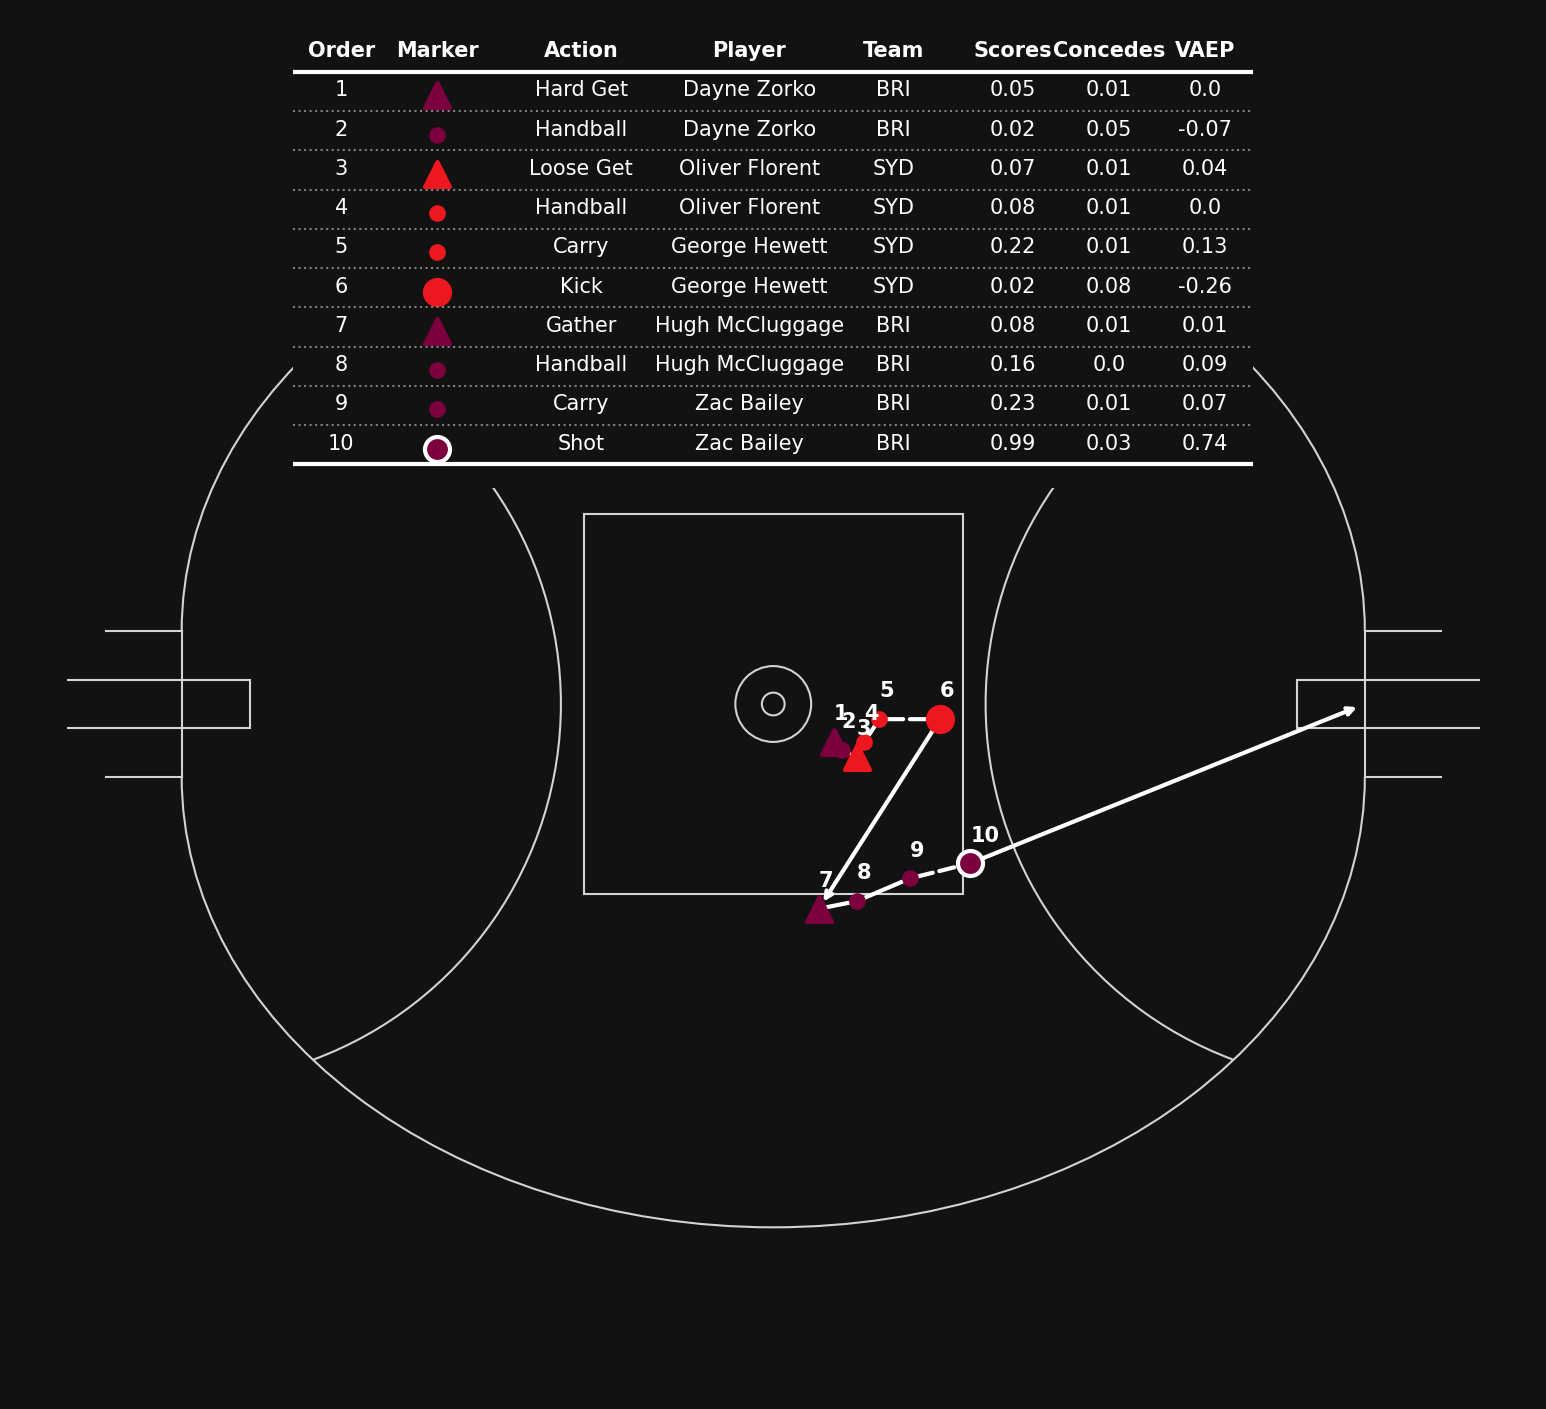

In [19]:
match_id = "202101_BrisbaneLions_Sydney"
chain_number = 1
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

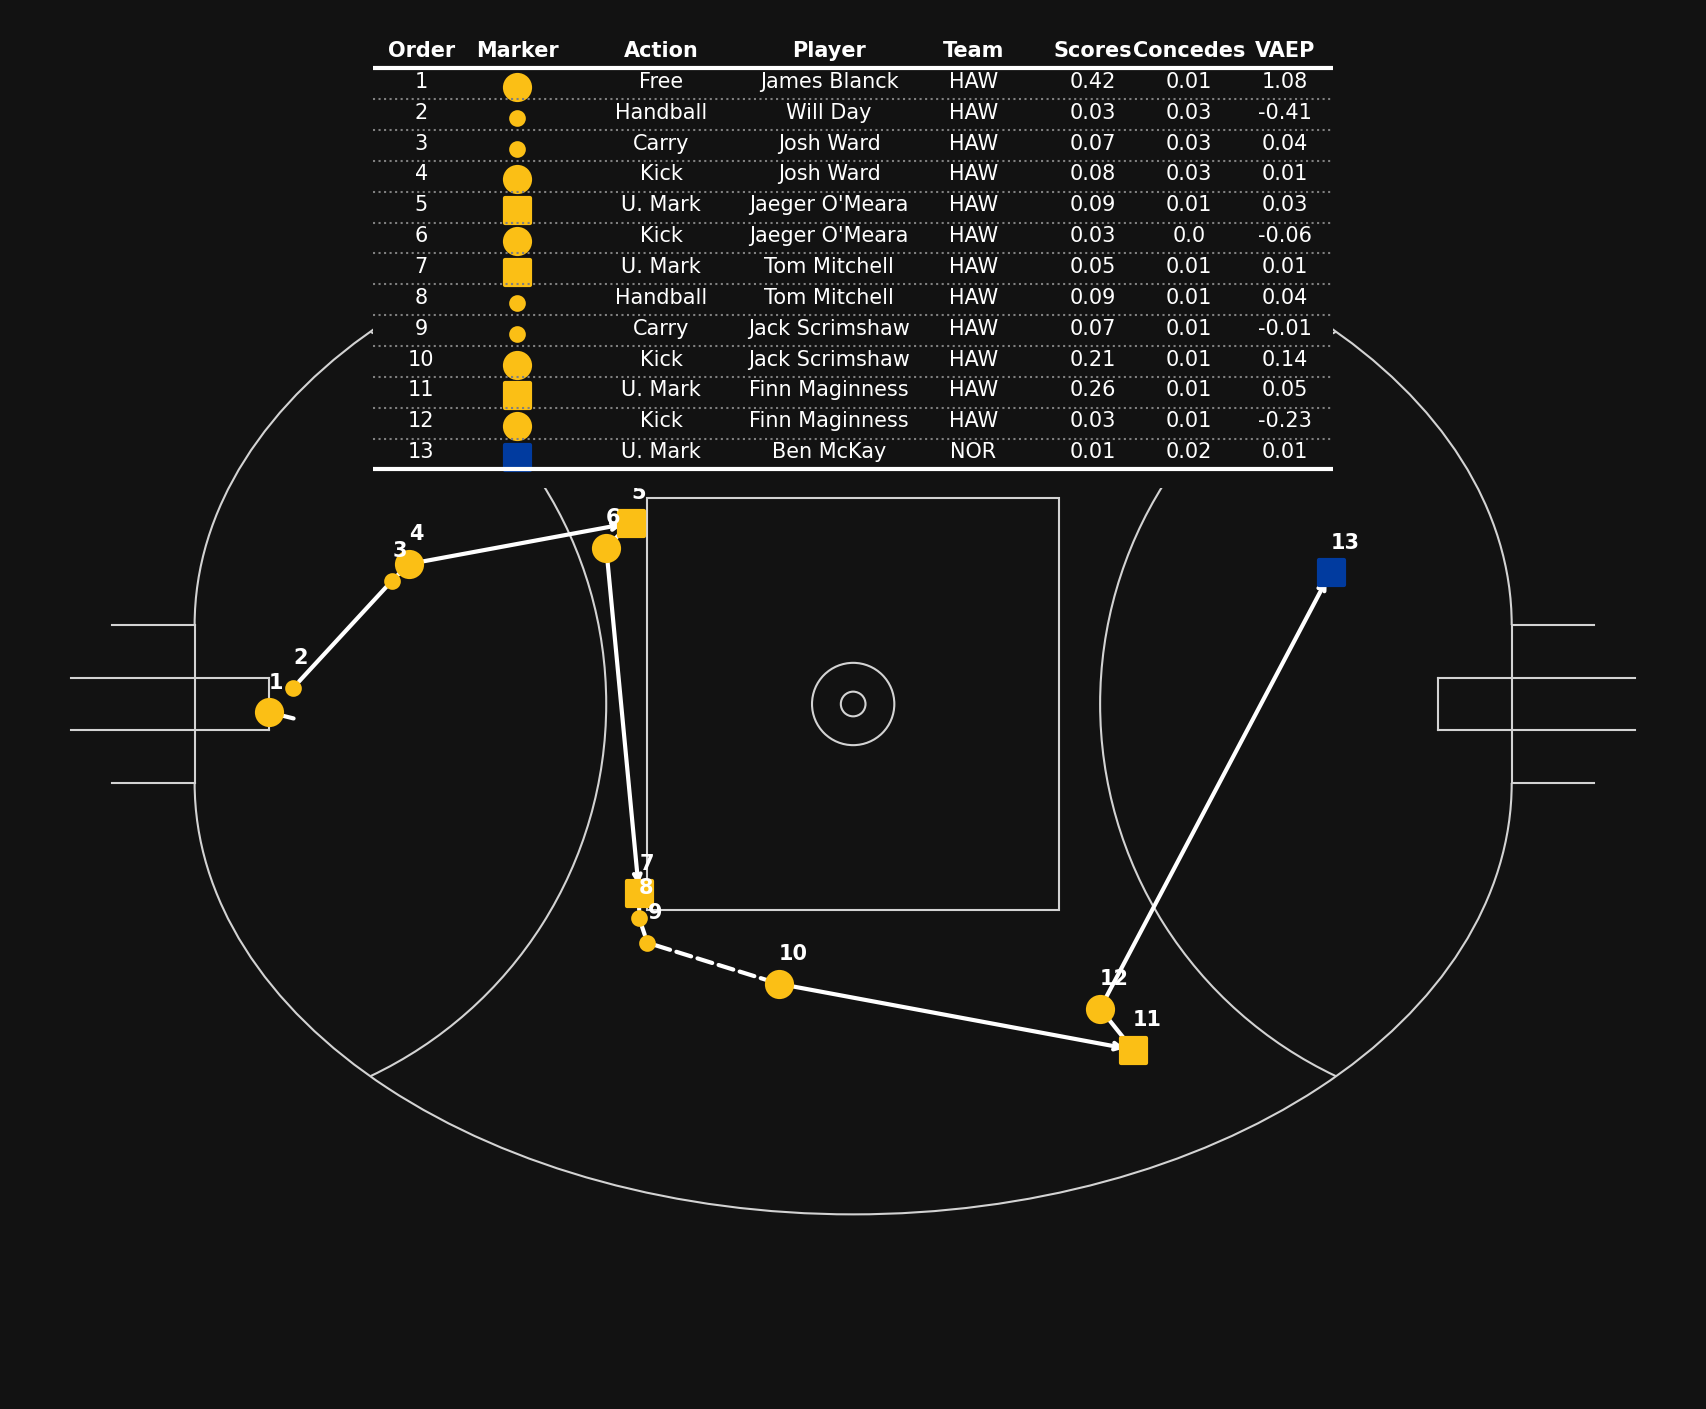

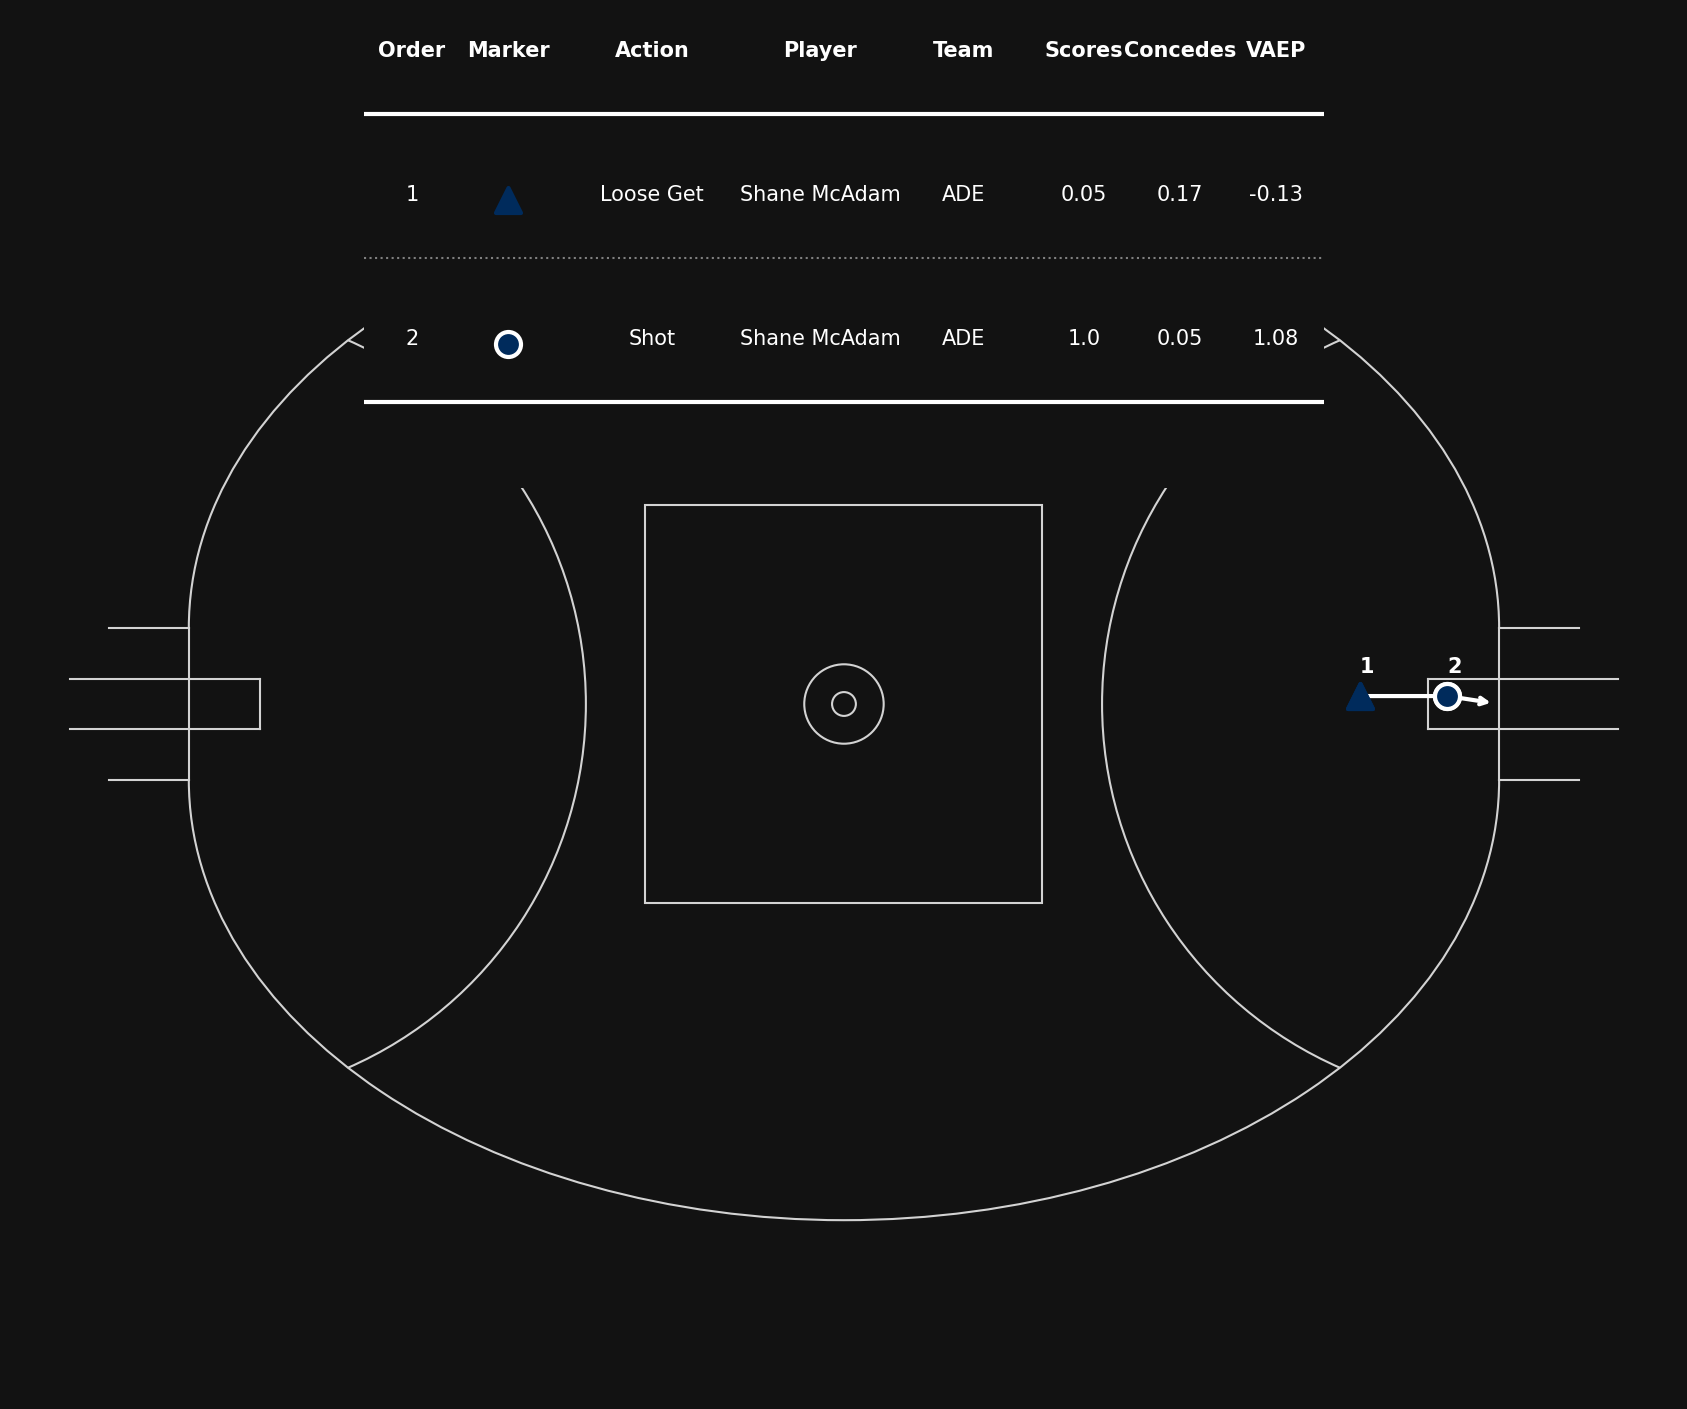

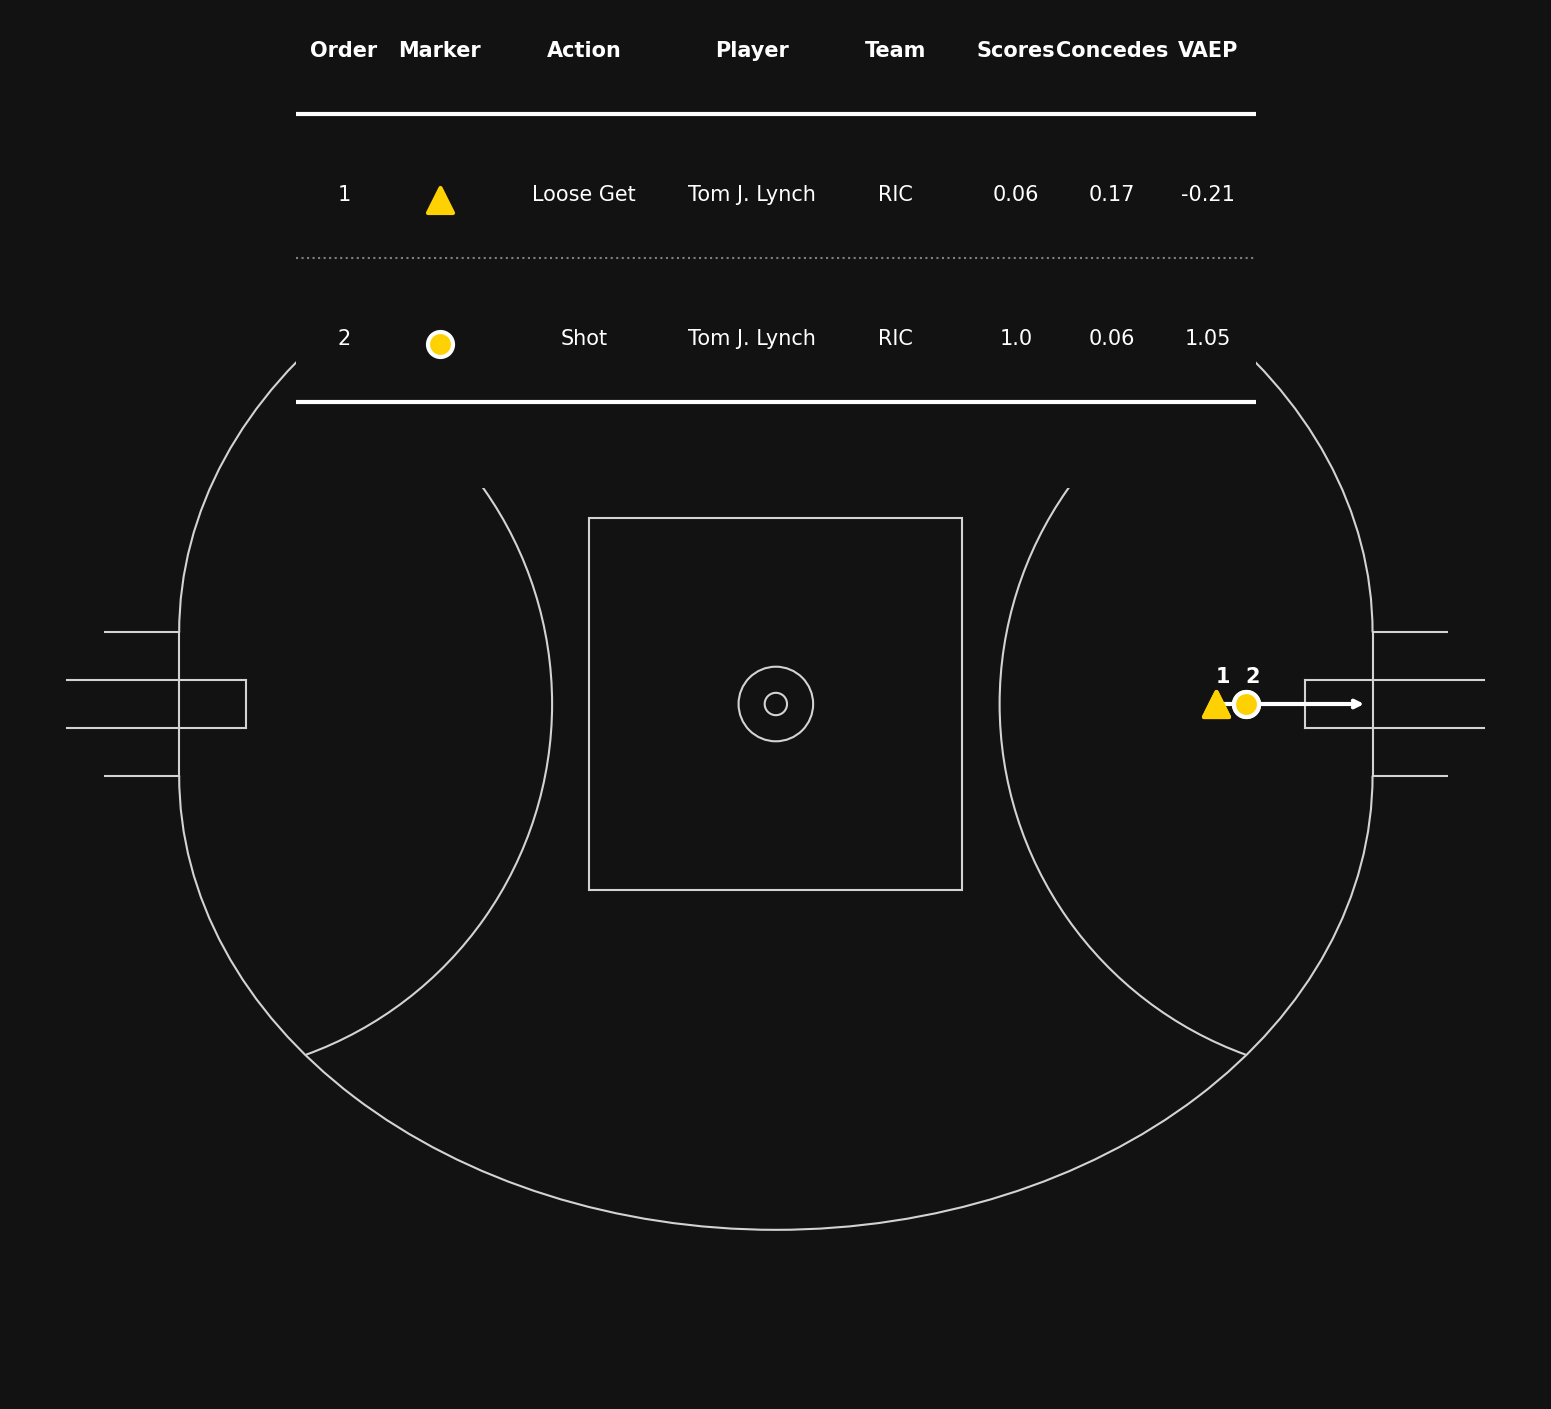

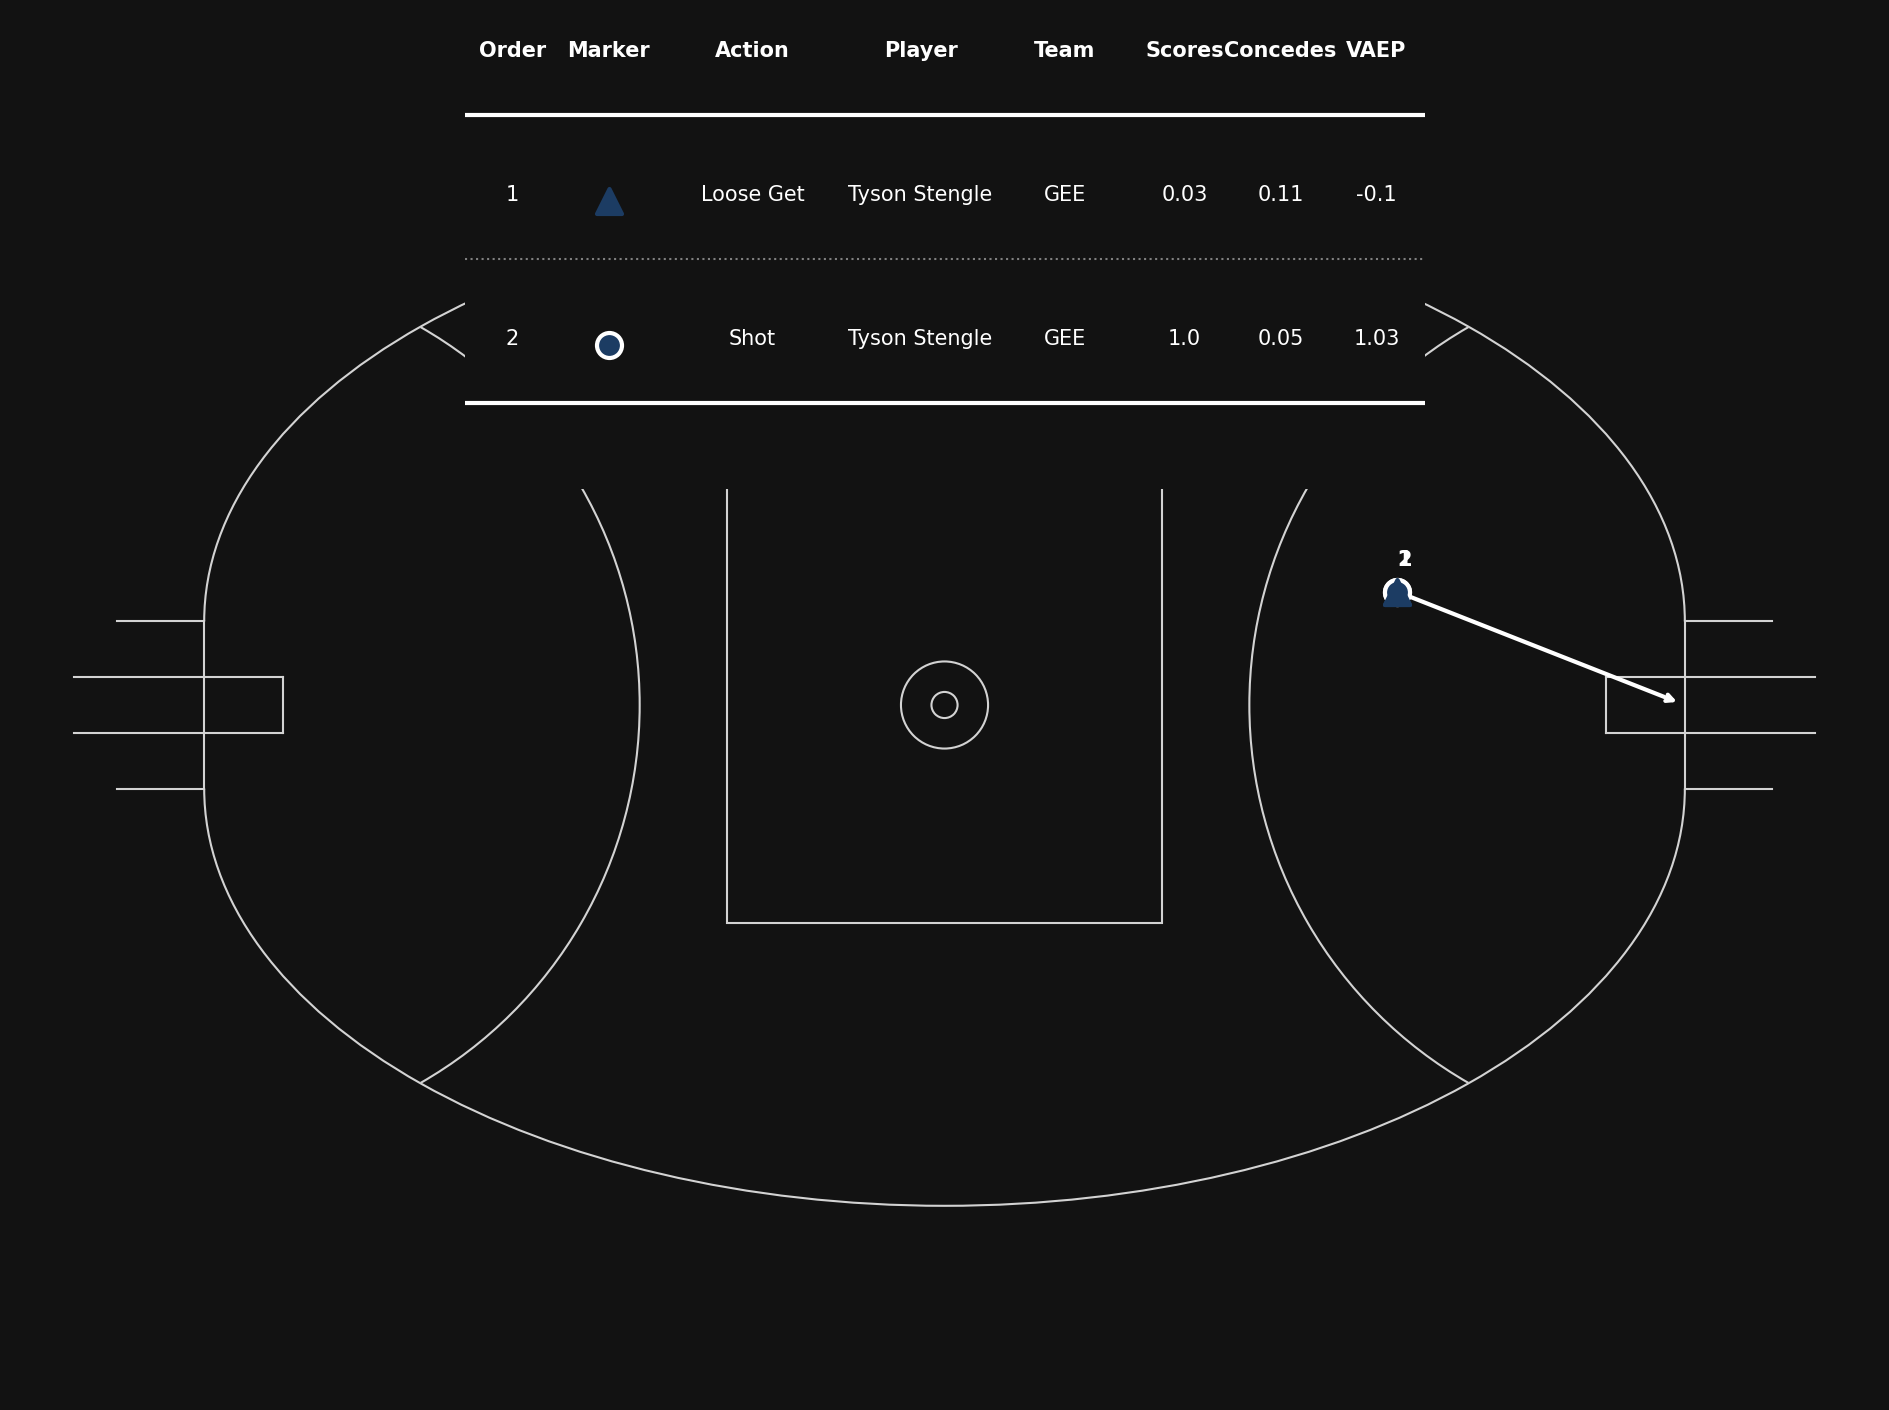

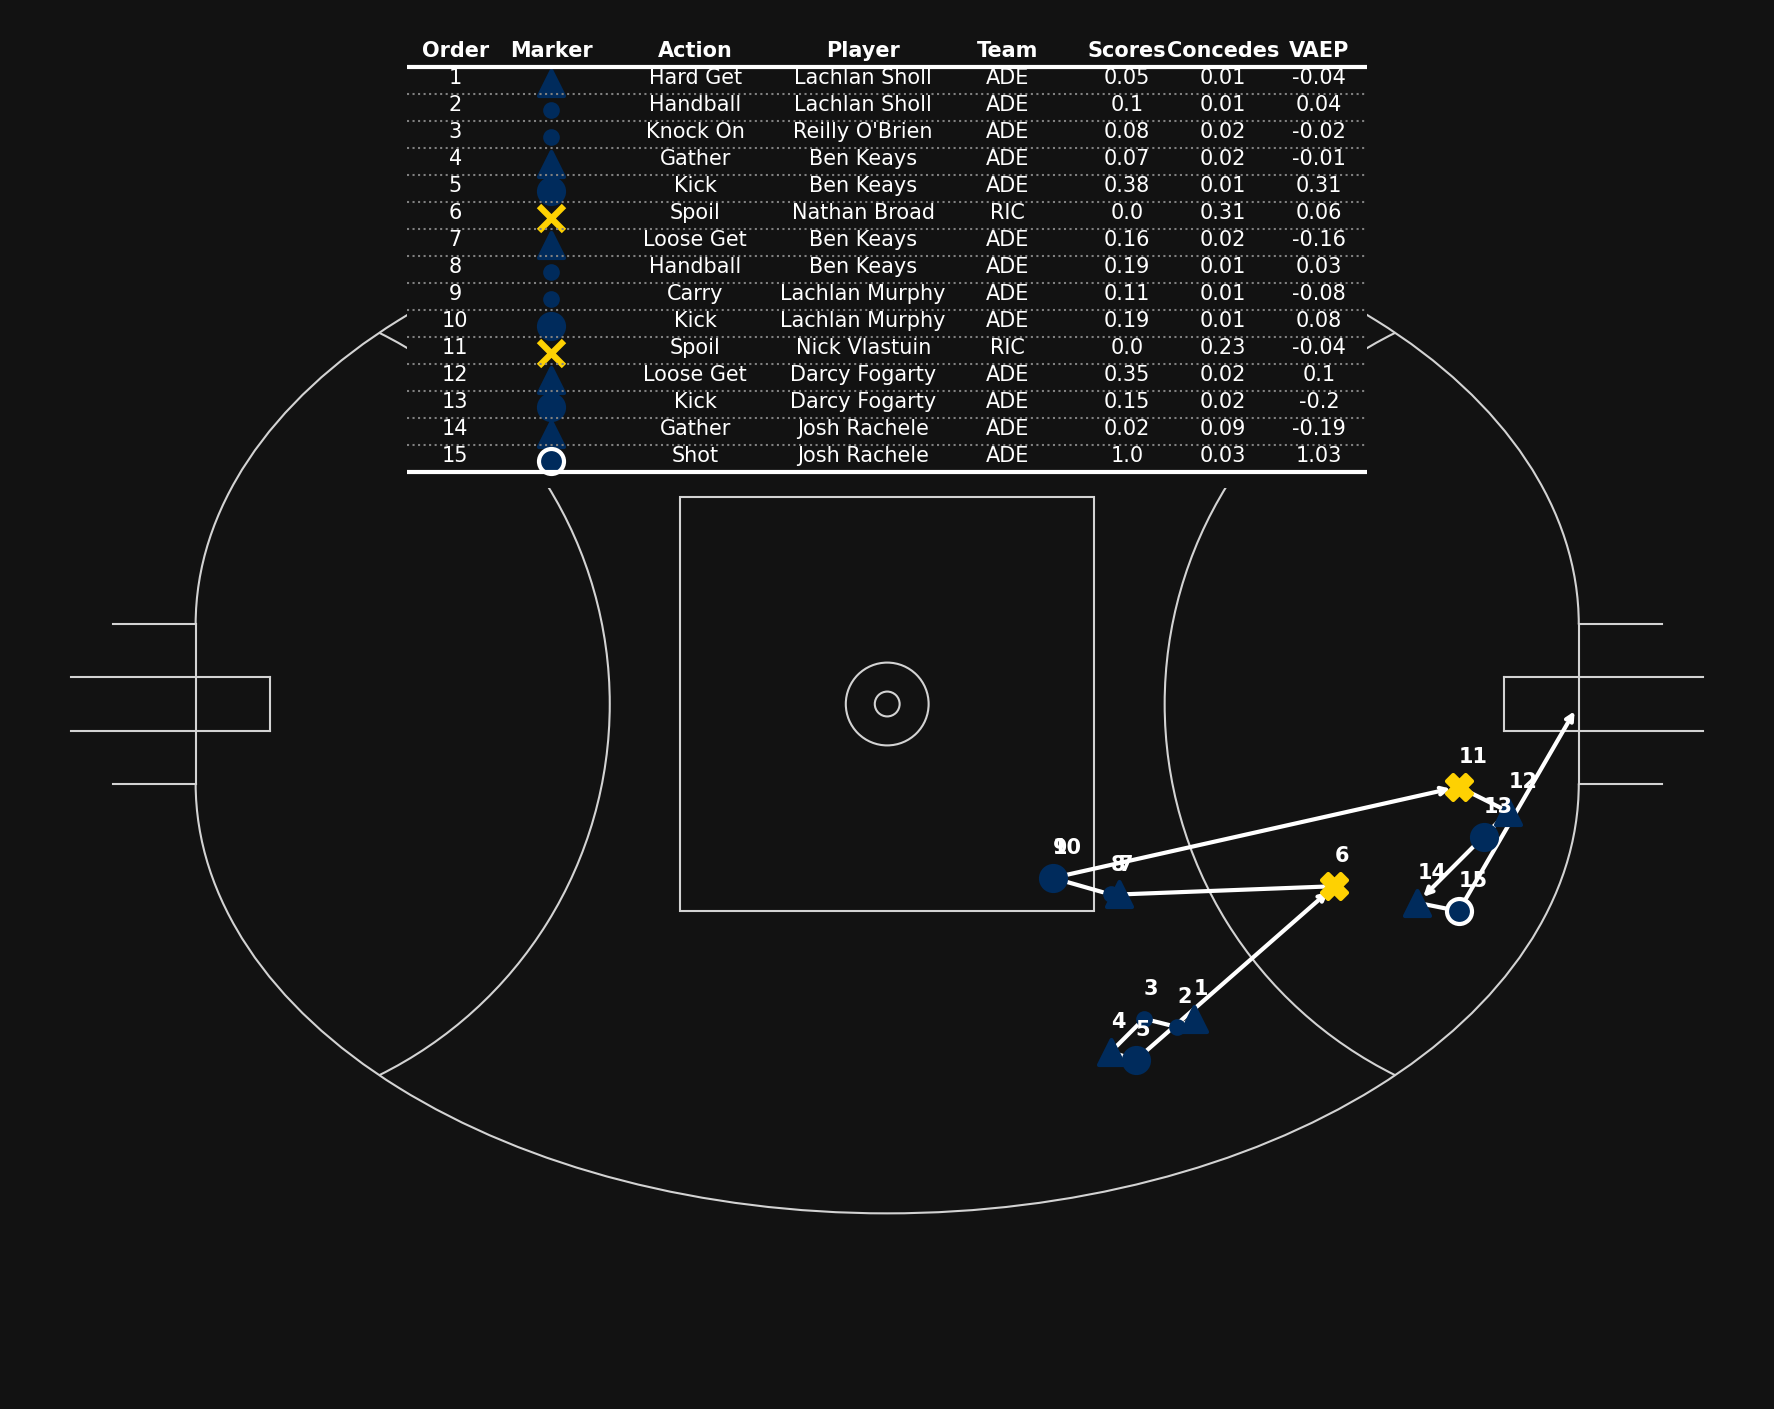

In [21]:
top_vaep_actions = chain_data.sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

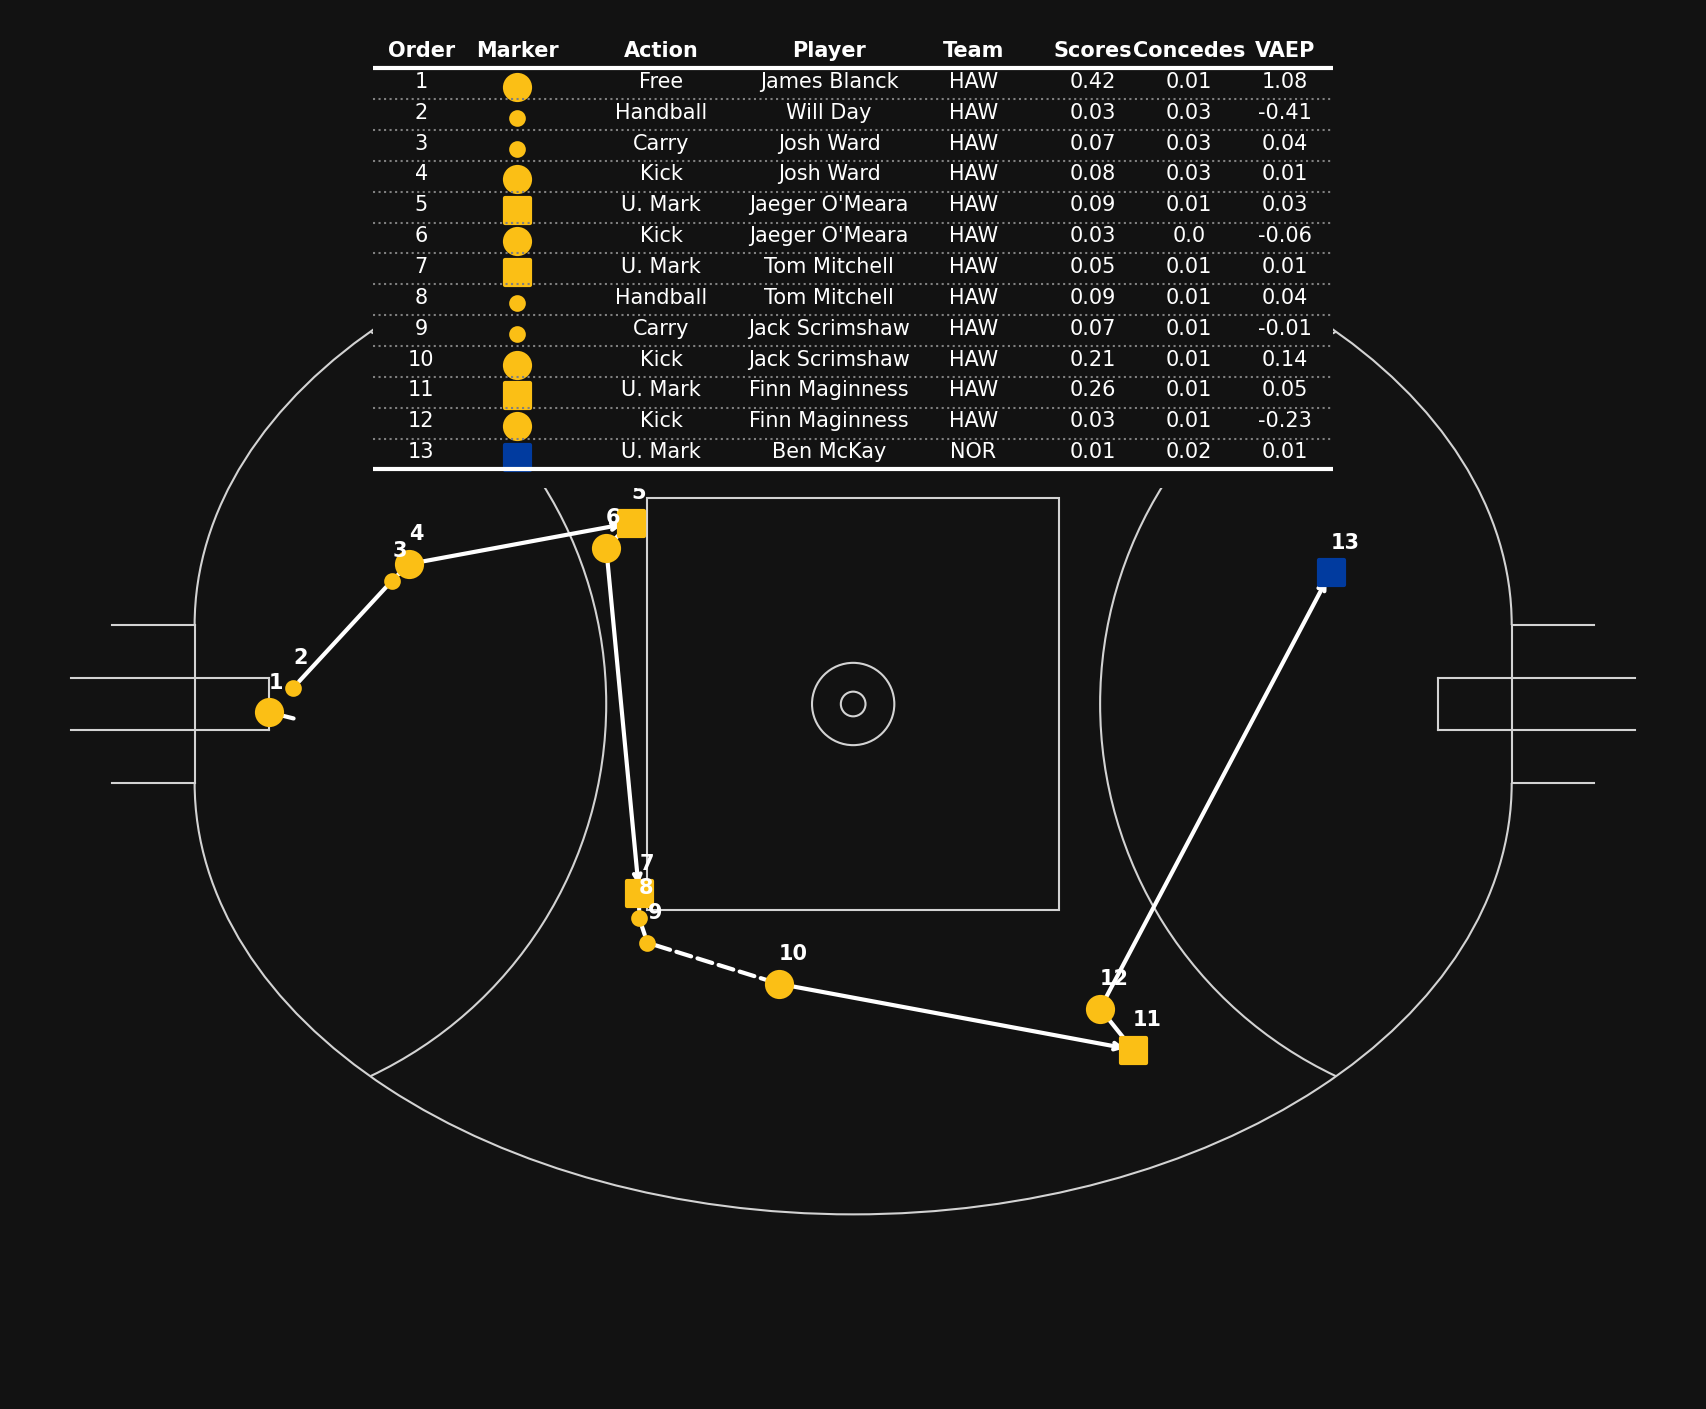

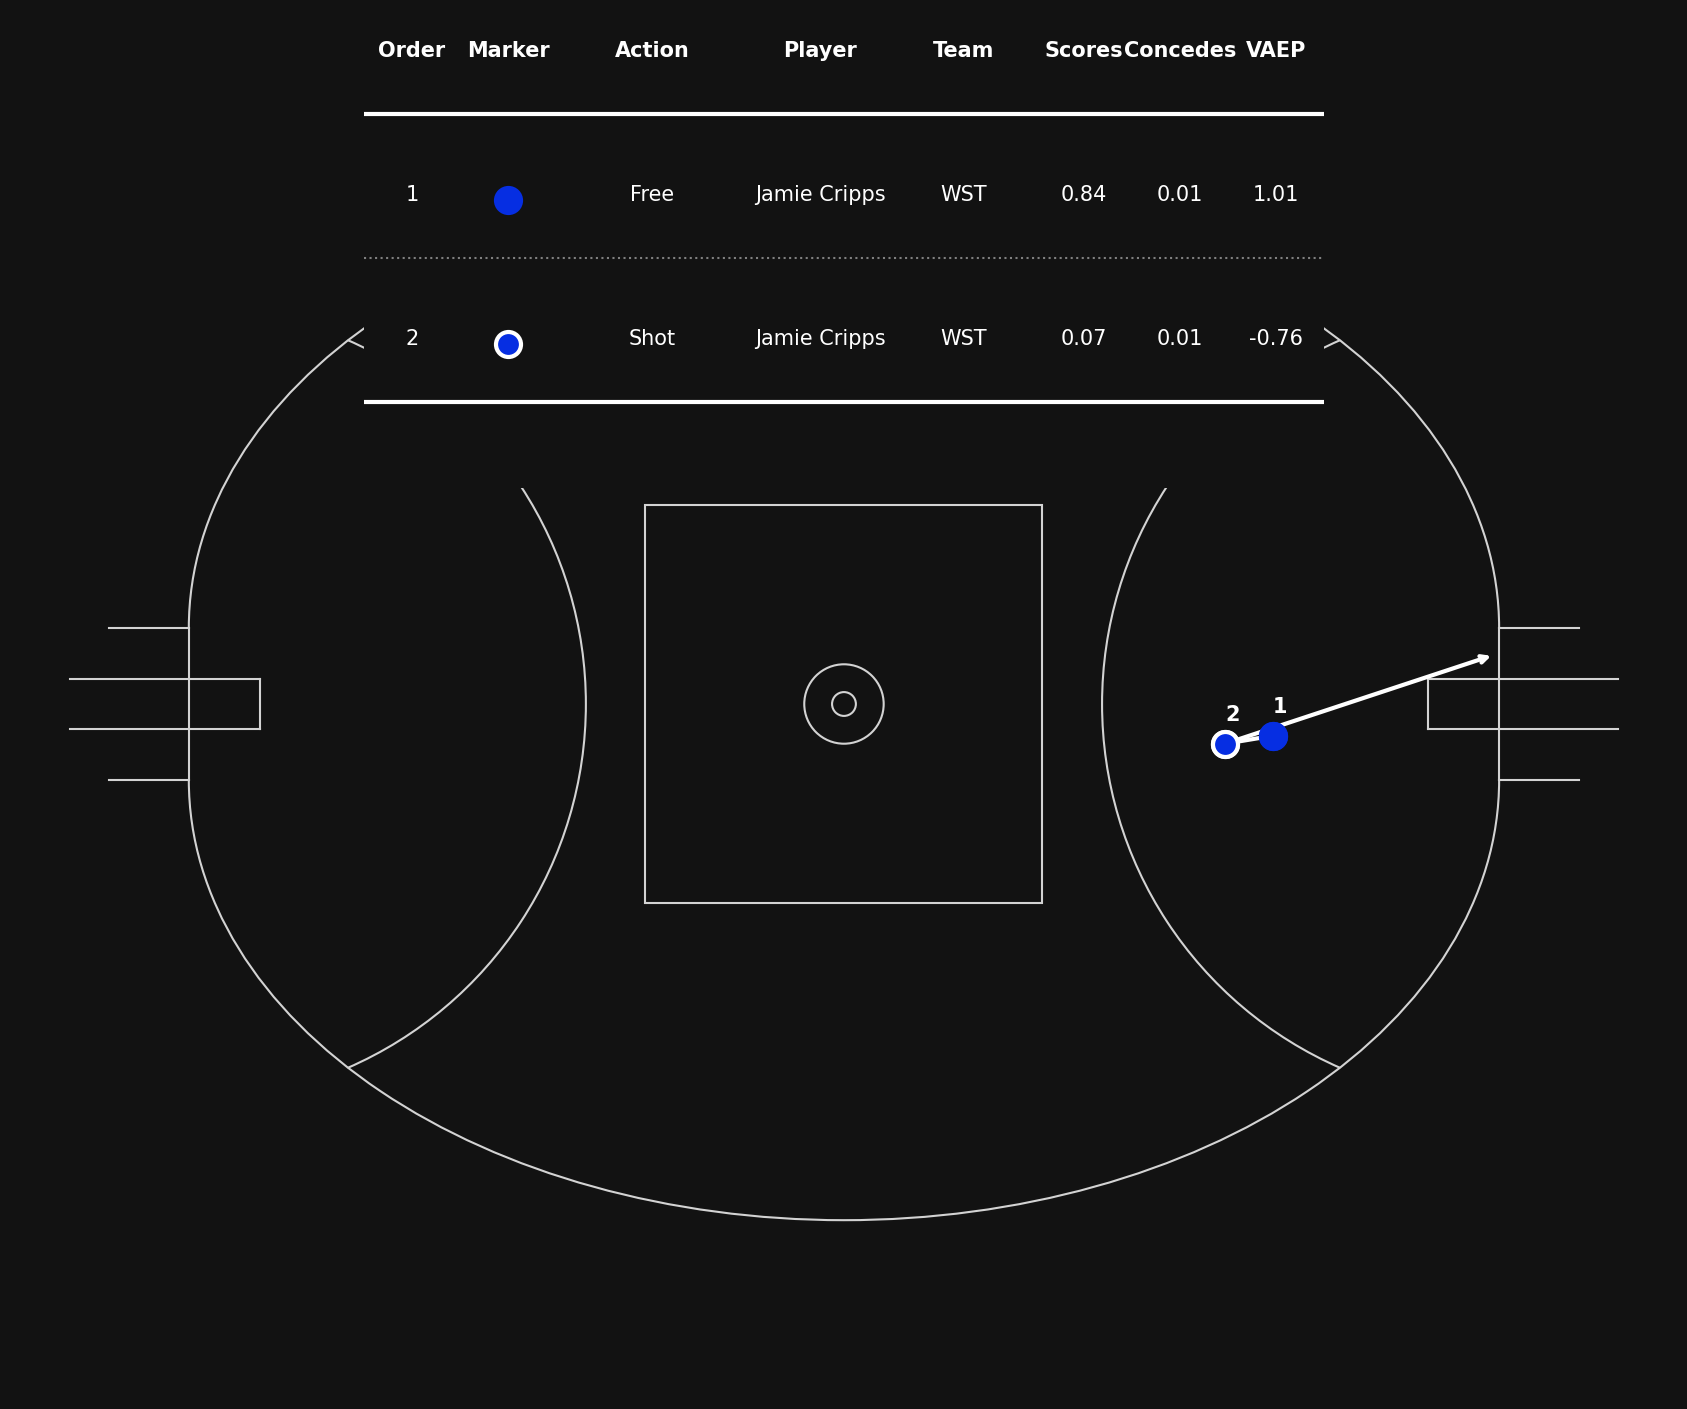

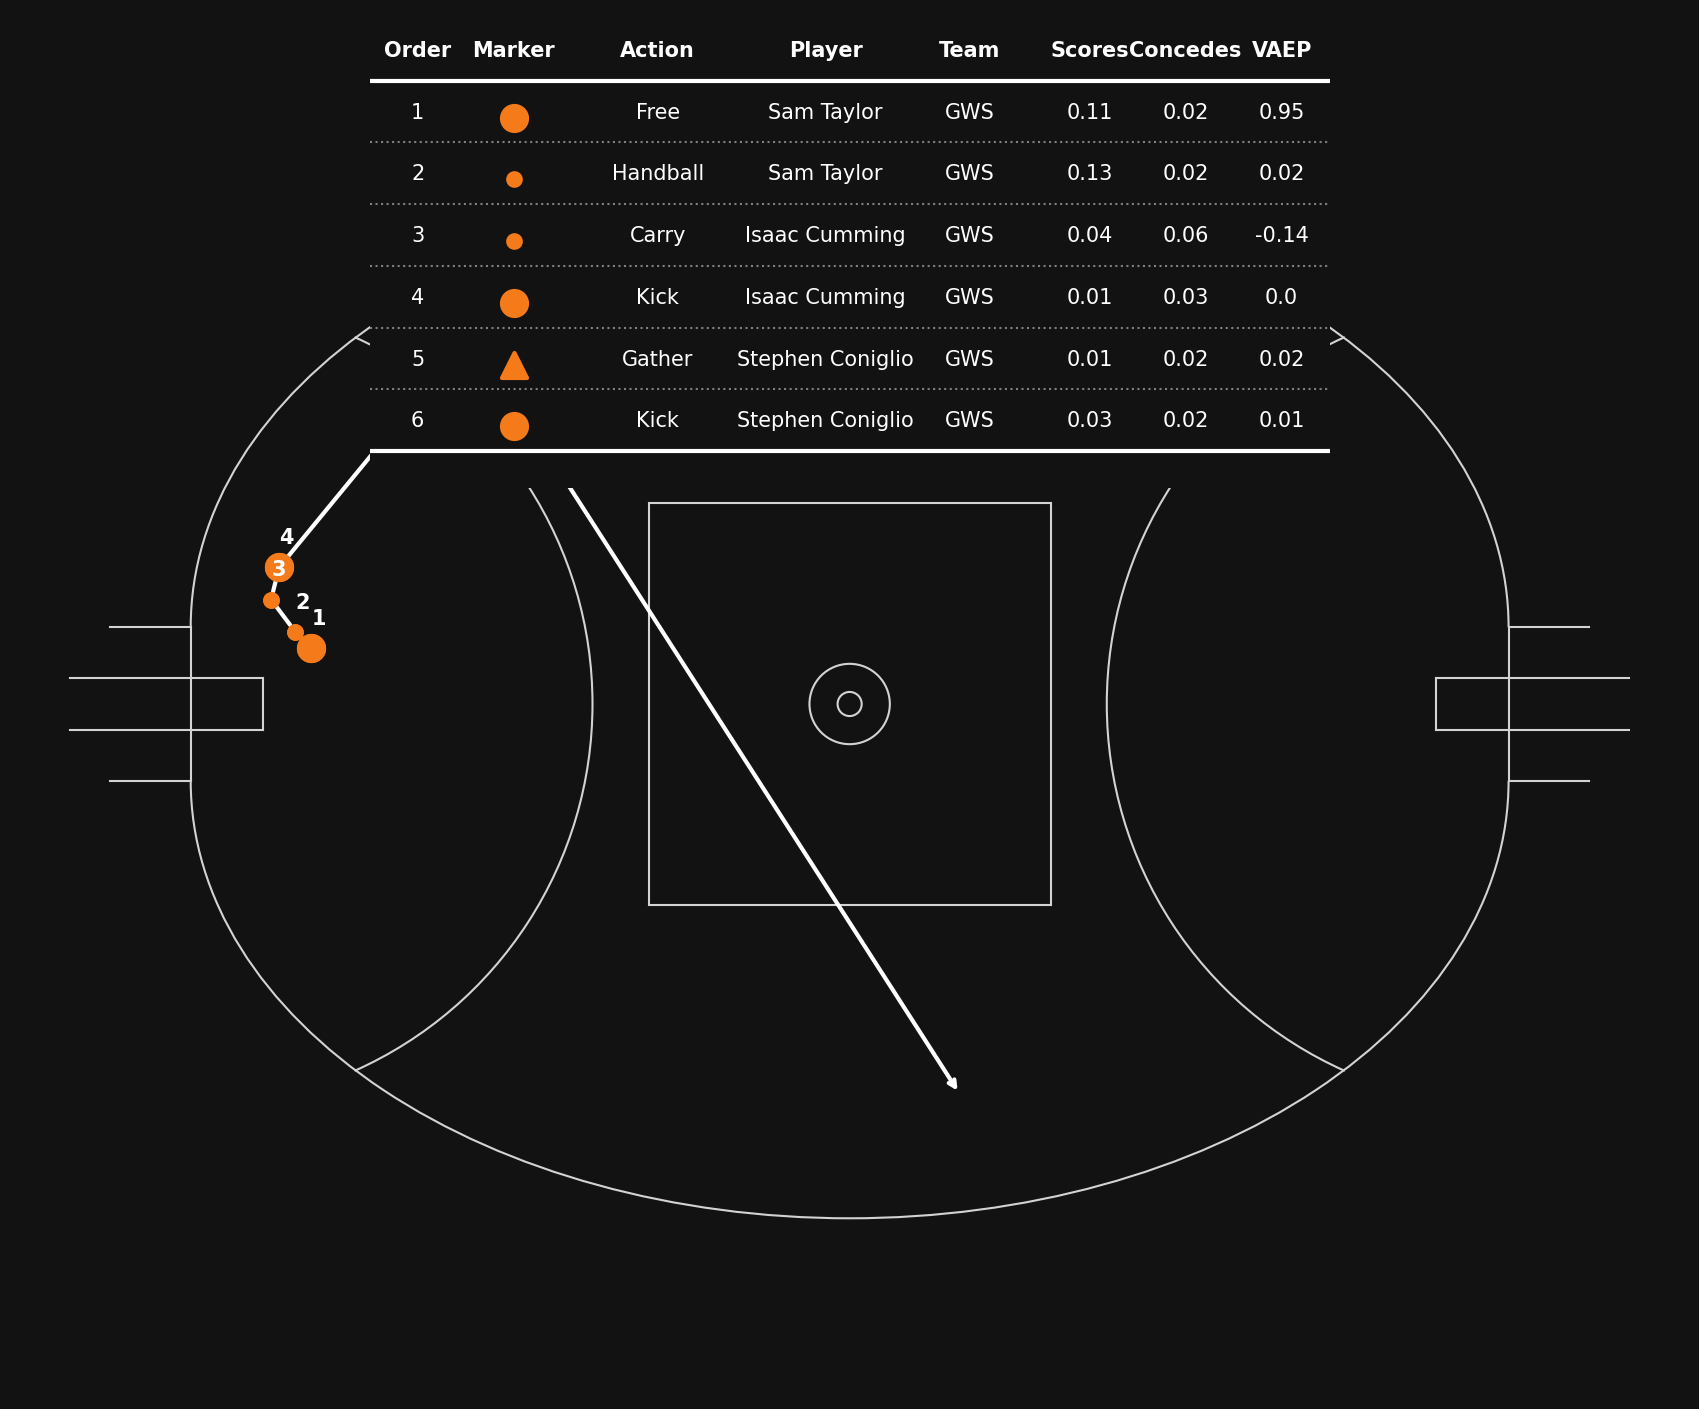

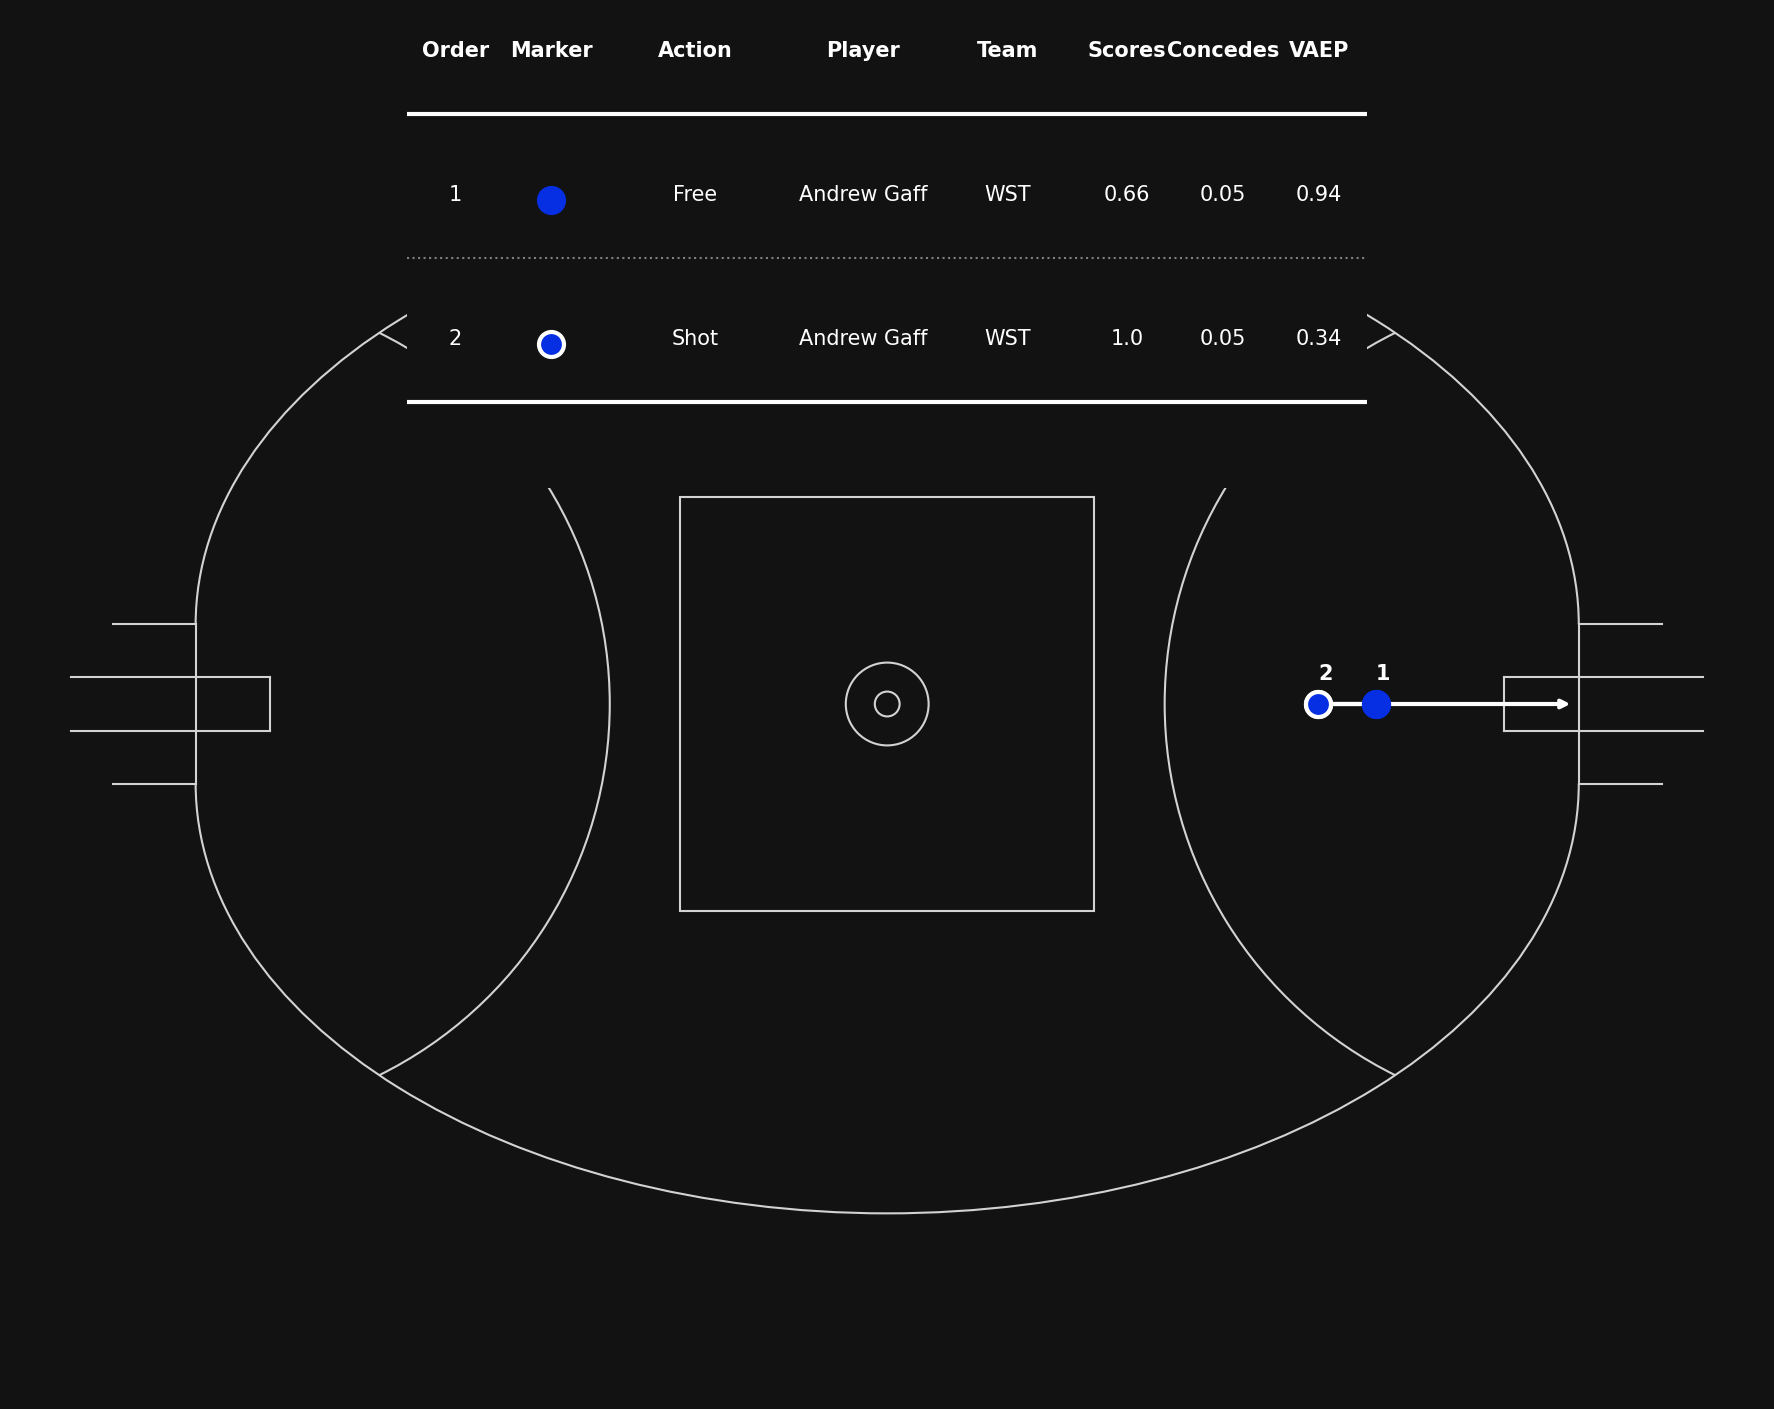

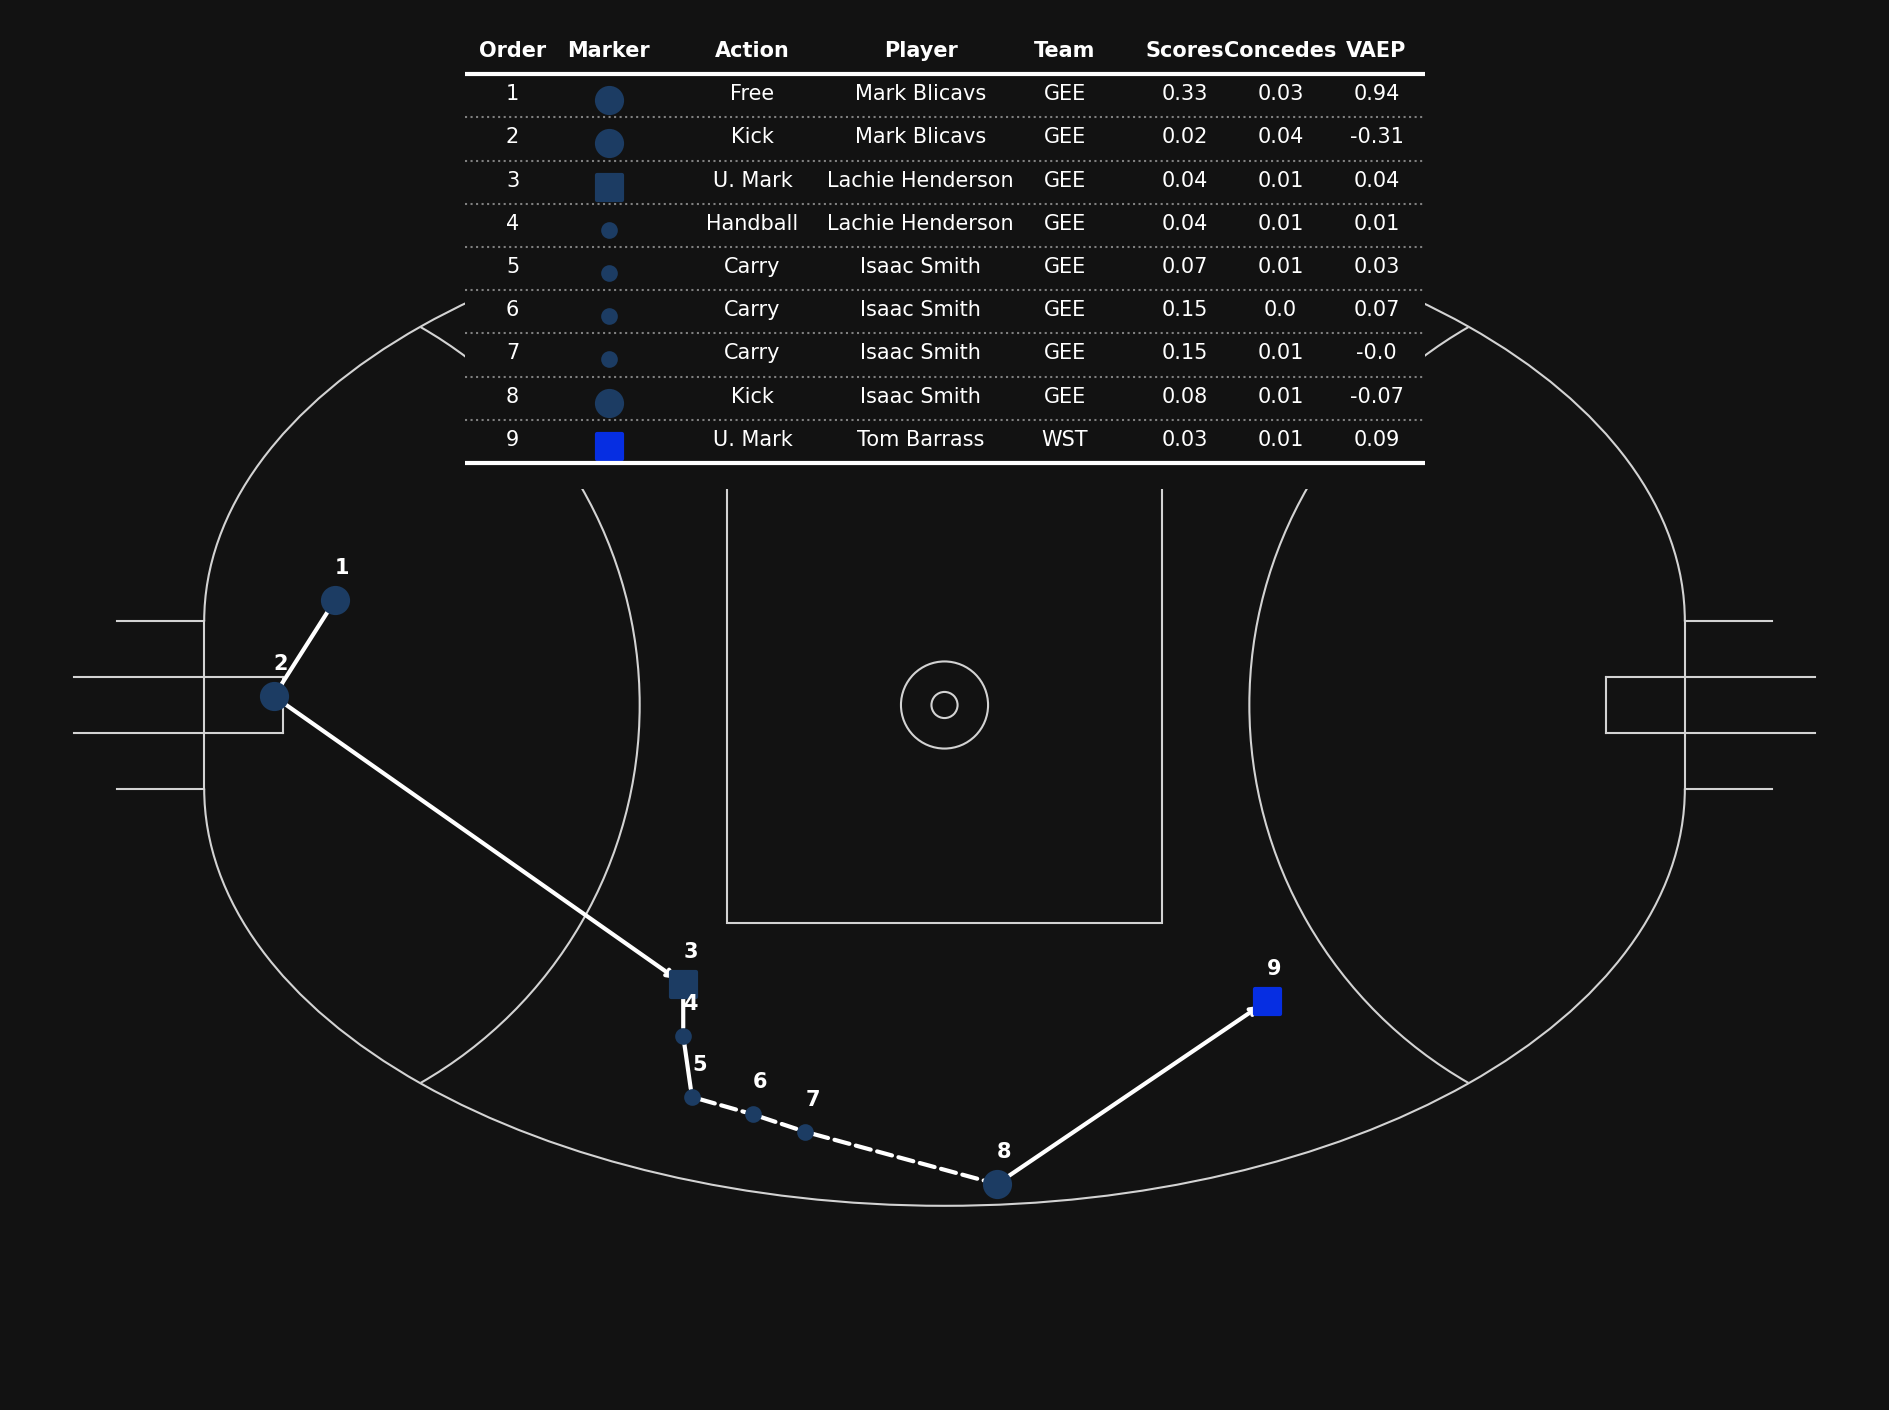

In [22]:
top_vaep_nonshot_actions = chain_data[~(chain_data['action_type'] == "Shot")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_nonshot_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_nonshot_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

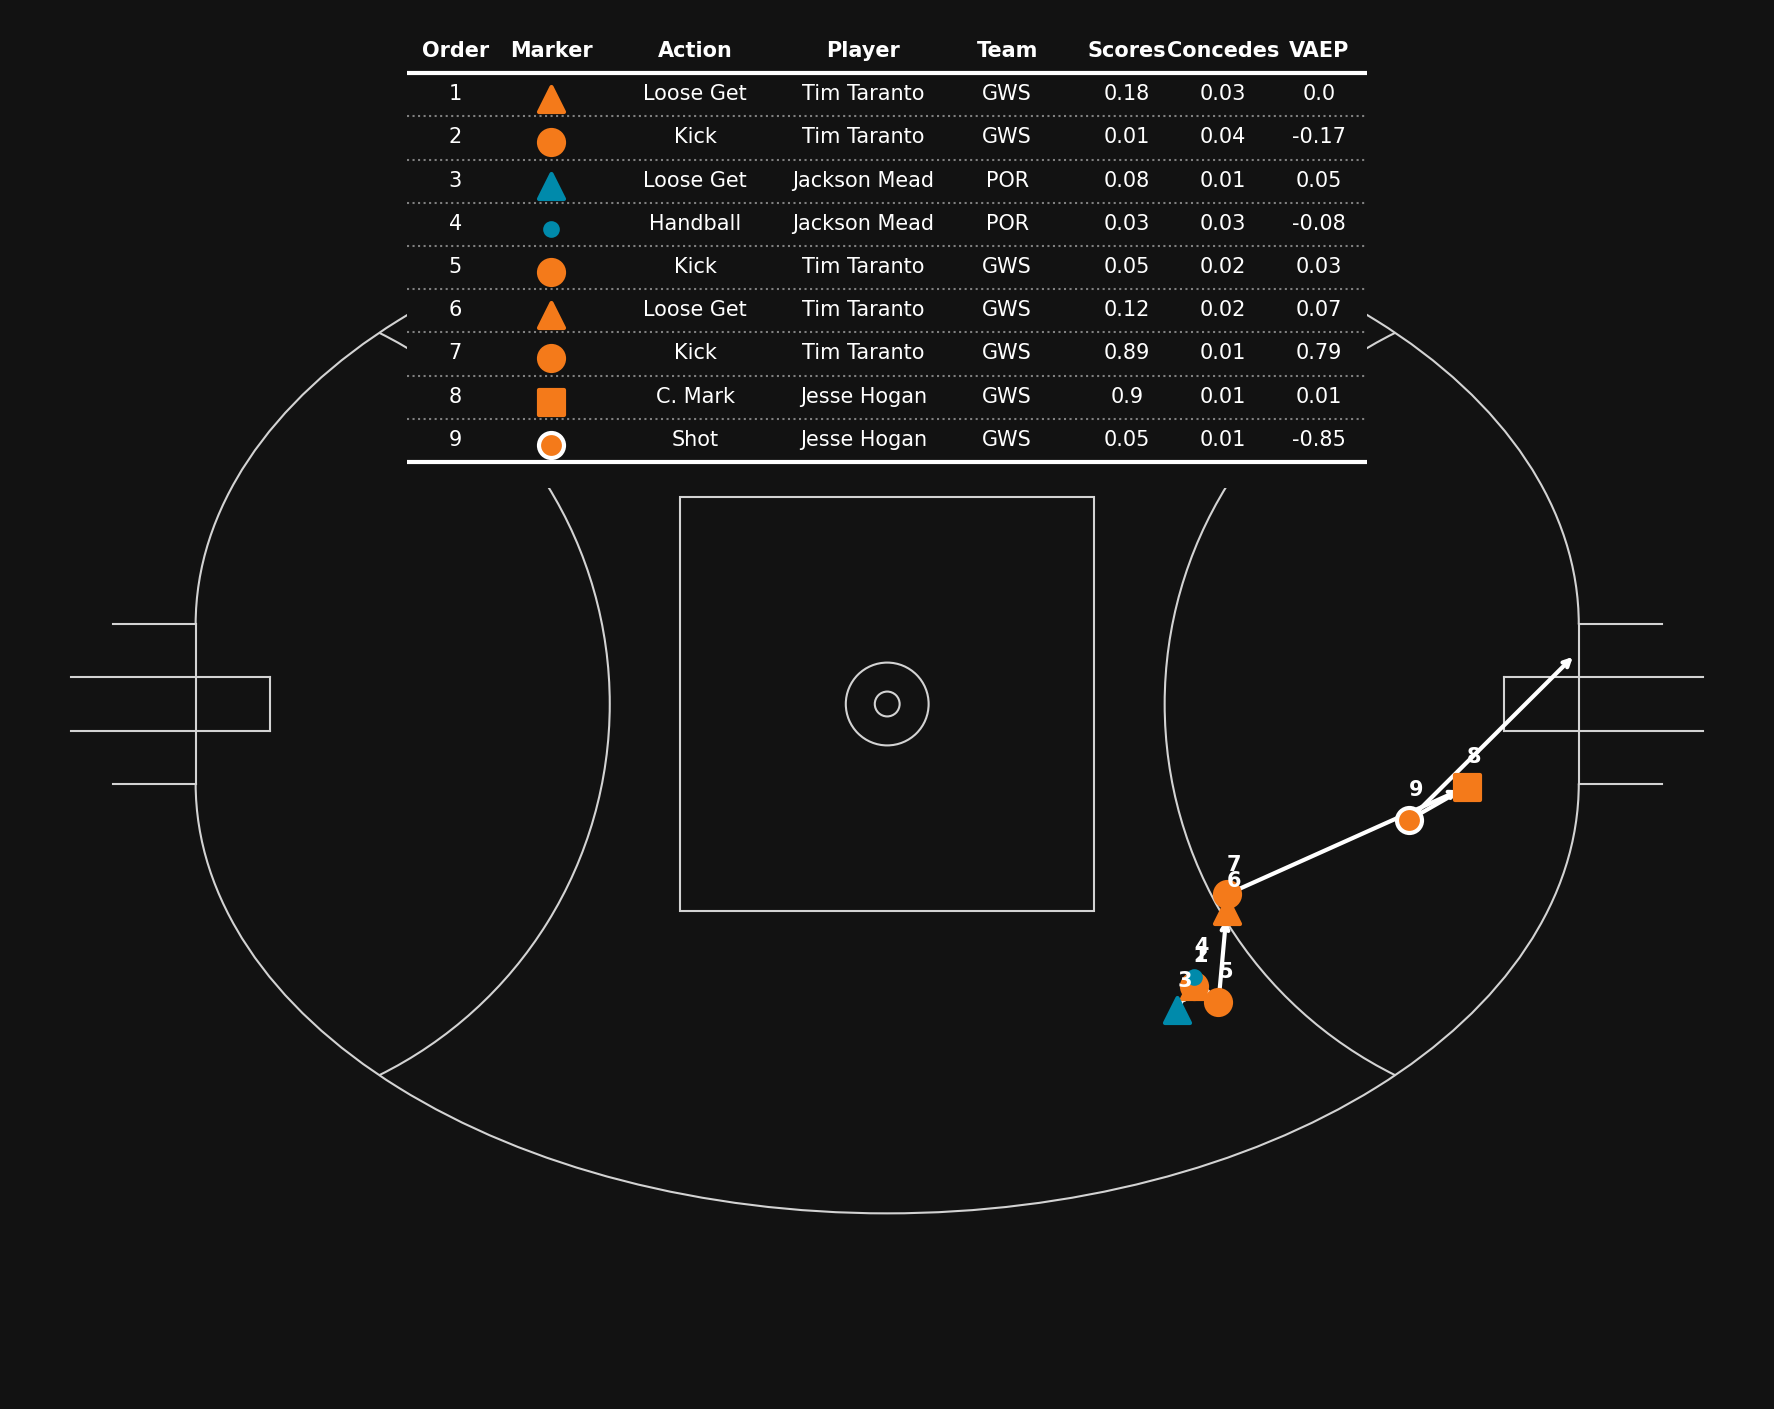

In [25]:
top_vaep_kick_actions = chain_data[(chain_data['action_type'] == "Kick")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_kick_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_kick_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

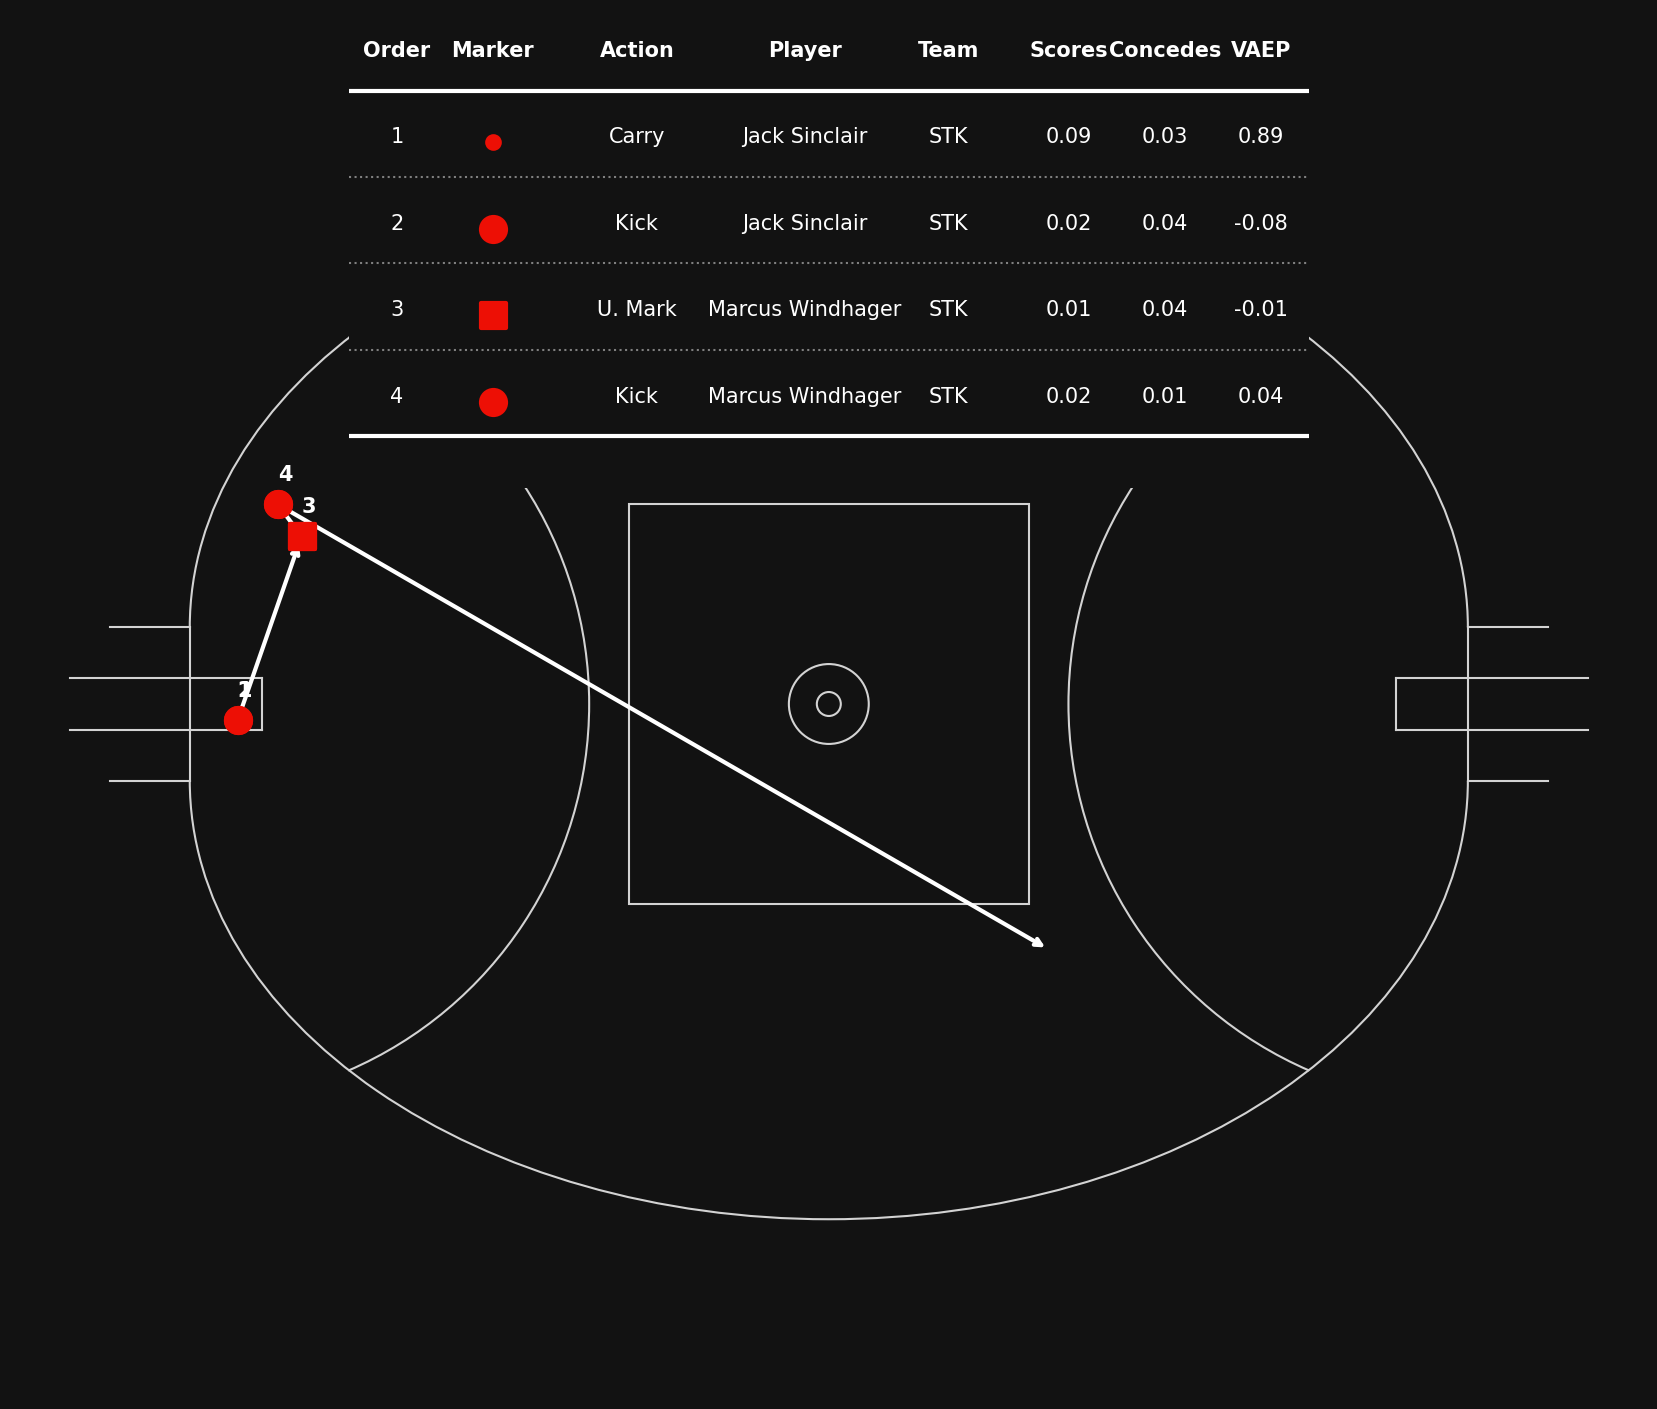

In [26]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Carry")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_carry_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_carry_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

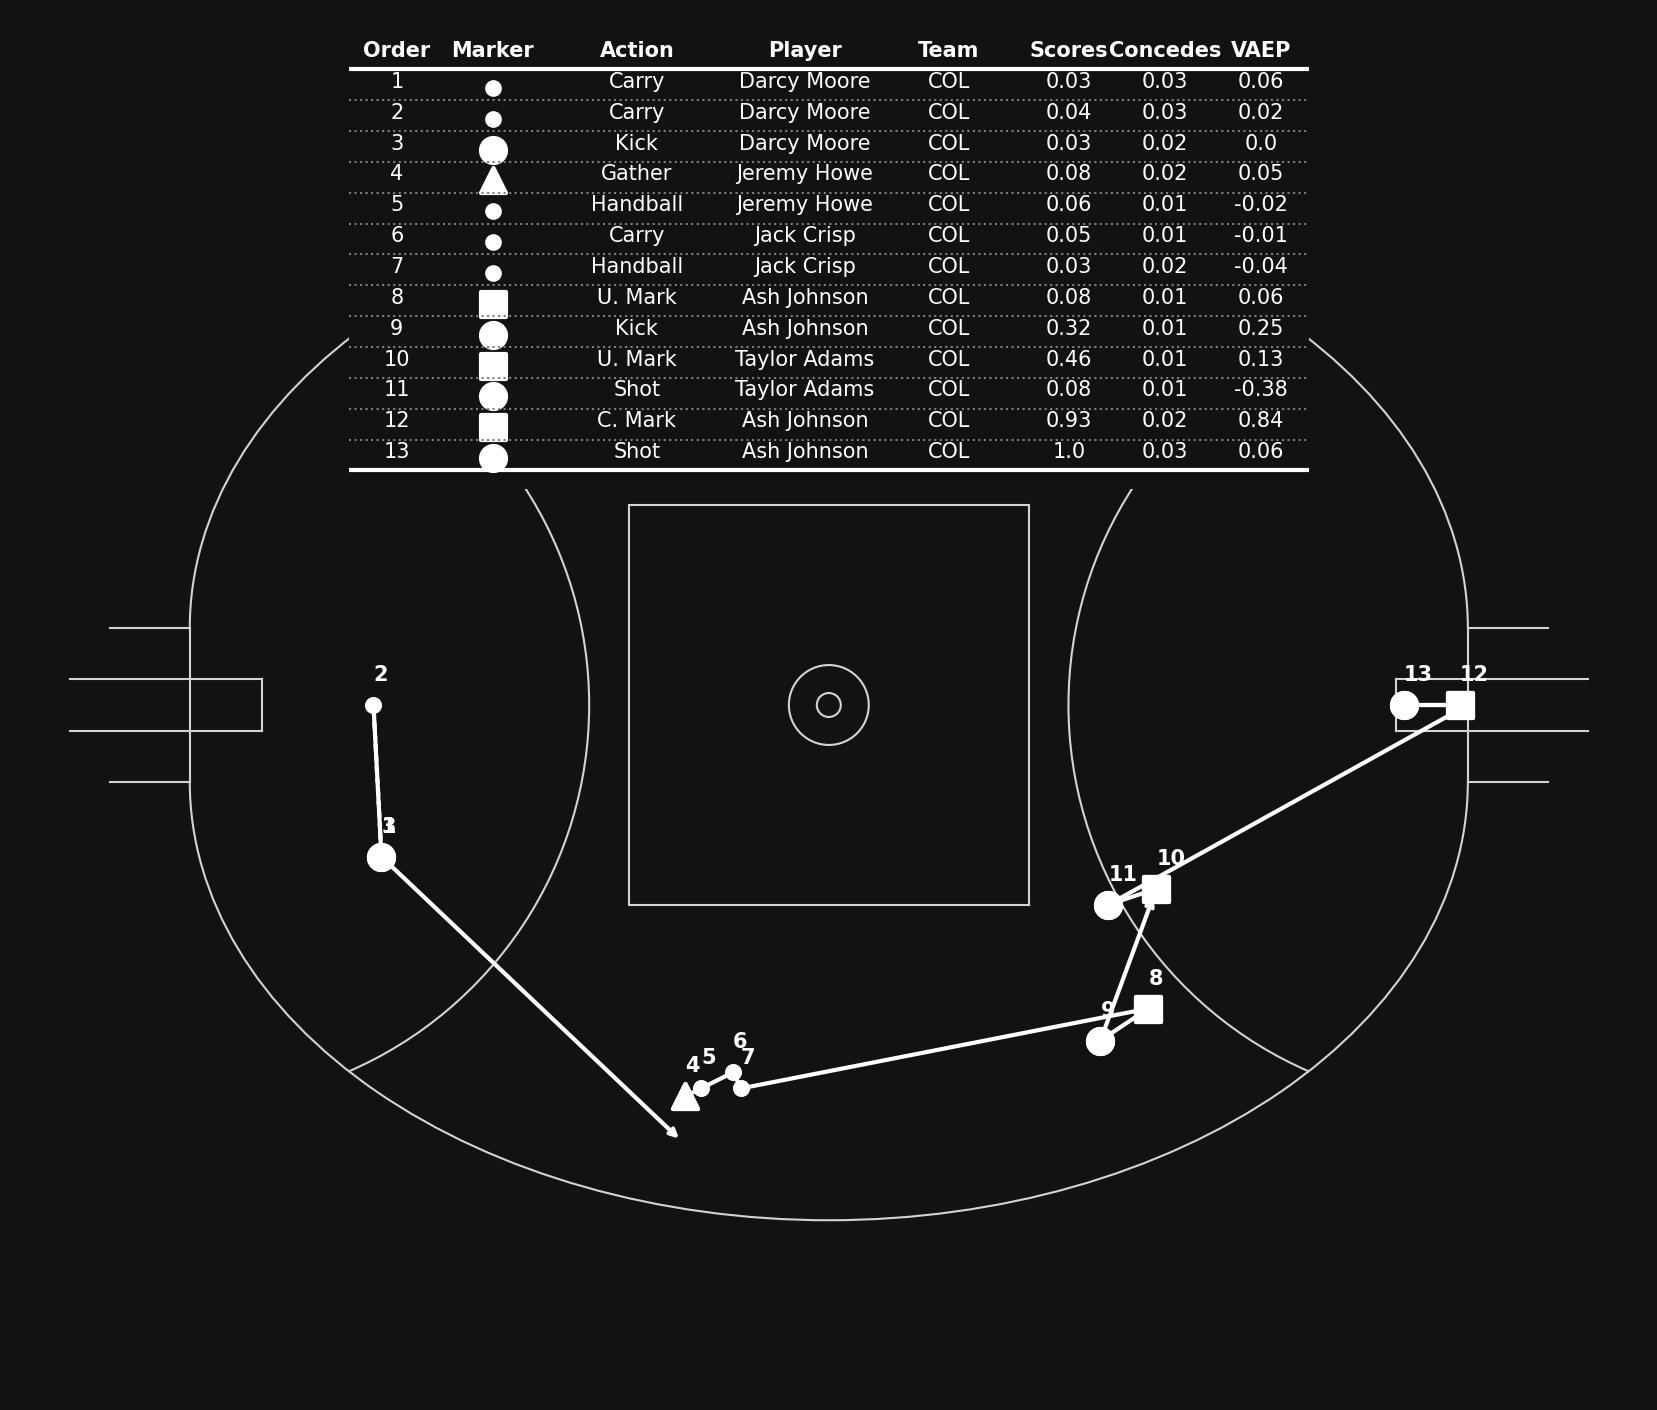

In [33]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Contested Mark")].sort_values('vaep_value', ascending = False).head(1)
match_id = top_vaep_carry_actions['Match_ID'].iloc[0]
chain_number = top_vaep_carry_actions['Chain_Number'].iloc[0]
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)

pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

plt.savefig(
	"../figures/20230814_vaep_chain.png",
	dpi = 300,
	facecolor = "#121212",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)